## Some very standard (or standard for astro) packages

In [1]:
import subprocess
import os
import sys
import glob
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astropy.units as u
import pandas as pd
import numdifftools as nd
import scipy.stats as ss
import arviz as az

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.modeling.powerlaws import BrokenPowerLaw1D
from astropy.constants import c

from scipy.special import iv
from scipy.optimize import curve_fit, differential_evolution

# Check if plots directory exists, if not create it
if not os.path.exists('plots'):
    os.makedirs('plots')

# My Version is: 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
print(sys.version)

3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]


## Plotting and formatting functions/options

In [2]:
# Formatting opinions
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.width'] = 2.5
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 9.0
mpl.rcParams['ytick.minor.size'] = .0

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.size'] = 9.0
mpl.rcParams['xtick.minor.size'] = 4.0
mpl.rcParams['xtick.labelbottom'] = True
mpl.rcParams['axes.linewidth'] = 1.5

# Function for putting UTC on top of axis
def FormatAxis(ax, mjd, dt = 10, interval=60):
    
    # For 1-D axis array
    if len(ax.shape) == 1:
        
        ax[0].set_xlabel('Observing Date (UTC)', fontfamily='serif')  
        ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
        ax[0].set_xlim(Time(mjd[0] - dt, format='mjd').datetime,Time(mjd[-1] + dt, format='mjd').datetime)
        ax[0].xaxis.set_label_position('top') 
        xformatter = mdates.DateFormatter('%Y-%m-%d')
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        ax[0].tick_params(axis='x', which='major',rotation=15, labeltop=True, labelbottom=False)
        xlabels = ax[0].get_xticklabels()
        ax[0].set_xticklabels(xlabels, rotation=15, ha='left')
    
        # Format secondary x-axis
        mjd_ax = ax[-1].secondary_xaxis('bottom', functions=(plot2mjd, mjd2plot))
        mjd_ax.set_xlabel('Observing Date (MJD)', fontfamily='serif')  
        mjd_ax.tick_params(which='major', direction='in', length = 0.0, width = 0.0)
        plt.draw()
    
        # Extract the labels
        mjd_ticks = []
        labels = ax[0].get_xticklabels(which='major')
        for lab in labels:
            mjd_ticks.append(lab.get_text() + 'T00:00:00')
    
        # Line up MJD and Datetime labels 
        mjd_ticks = (Time(mjd_ticks, format='isot').mjd).astype(int)
        mjd_ax.set_xticks(mjd_ticks, labels = mjd_ticks)

    # For 2-D axis array
    if len(ax.shape) == 2:
        for i in range(ax.shape[1]):
    
            ax[0, i].set_xlabel('Observing Date (UTC)', fontfamily='serif')  
            ax[0, i].xaxis.set_major_locator(mdates.DayLocator(interval=interval[i]))
            ax[0, i].set_xlim(Time(mjd[i][0] - dt[i], format='mjd').datetime,Time(mjd[i][-1] + dt[i], format='mjd').datetime)
            ax[0, i].xaxis.set_label_position('top') 
            xformatter = mdates.DateFormatter('%Y-%m-%d')
            plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
            ax[0, i].tick_params(axis='x', which='major',rotation=15, labeltop=True, labelbottom=False)
            xlabels = ax[0, i].get_xticklabels()
            ax[0, i].set_xticklabels(xlabels, rotation=15, ha='left')
    
            # Format secondary x-axis
            mjd_ax = ax[-1, i].secondary_xaxis('bottom', functions=(plot2mjd, mjd2plot))
            mjd_ax.set_xlabel('Observing Date (MJD)', fontfamily='serif')  
            mjd_ax.tick_params(which='major', direction='in', length = 0.0, width = 0.0)
            plt.draw()

            # Extract the labels
            mjd_ticks = []
            labels = ax[0, i].get_xticklabels(which='major')
            for lab in labels:
                mjd_ticks.append(lab.get_text() + 'T00:00:00')
        
            # Line up MJD and Datetime labels 
            mjd_ticks = (Time(mjd_ticks, format='isot').mjd).astype(int)
            mjd_ax.set_xticks(mjd_ticks, labels = mjd_ticks)
    
def plot2mjd(t):
    '''Convert from matplotlib plot date to mjd'''
    return Time(t, format="plot_date", scale='utc').mjd

def mjd2plot(mjd):
    '''Convert from mjd to matplotlib plot'''
    return Time(mjd, format="mjd", scale='utc').plot_date

# Stupid matplotlib sh*t from here -- https://stackoverflow.com/questions/46694889/matplotlib-sharex-with-colorbar-not-working
def align_axis_x(ax, ax_target):
    """Make x-axis of `ax` aligned with `ax_target` in figure"""
    posn_old, posn_target = ax.get_position(), ax_target.get_position()
    ax.set_position([posn_target.x0, posn_old.y0, posn_target.width, posn_old.height])

## Big radio light curve also highlighting the hard state times

This section displays the full multi-wavelength light curve of Swift J1727.8-1613, focusing on the evolution of the radio core emission and its relation to X-ray state transitions.


**Highlights:**
- Vertical lines mark hard-to-soft and soft-to-hard state transitions (from literature).
- Shaded regions indicate periods classified as the hard state (rise and decay).
- "Rise" and "Decay" labels clarify the outburst phase.
- Both UTC and MJD dates are shown for reference.
- Legends and color bars distinguish telescopes and frequencies.

**Purpose:**  
This overview provides context for the timing and spectral evolution of the outburst, and serves as a reference for subsequent, more detailed analysis steps.

/tmp/ipykernel_259077/892713787.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


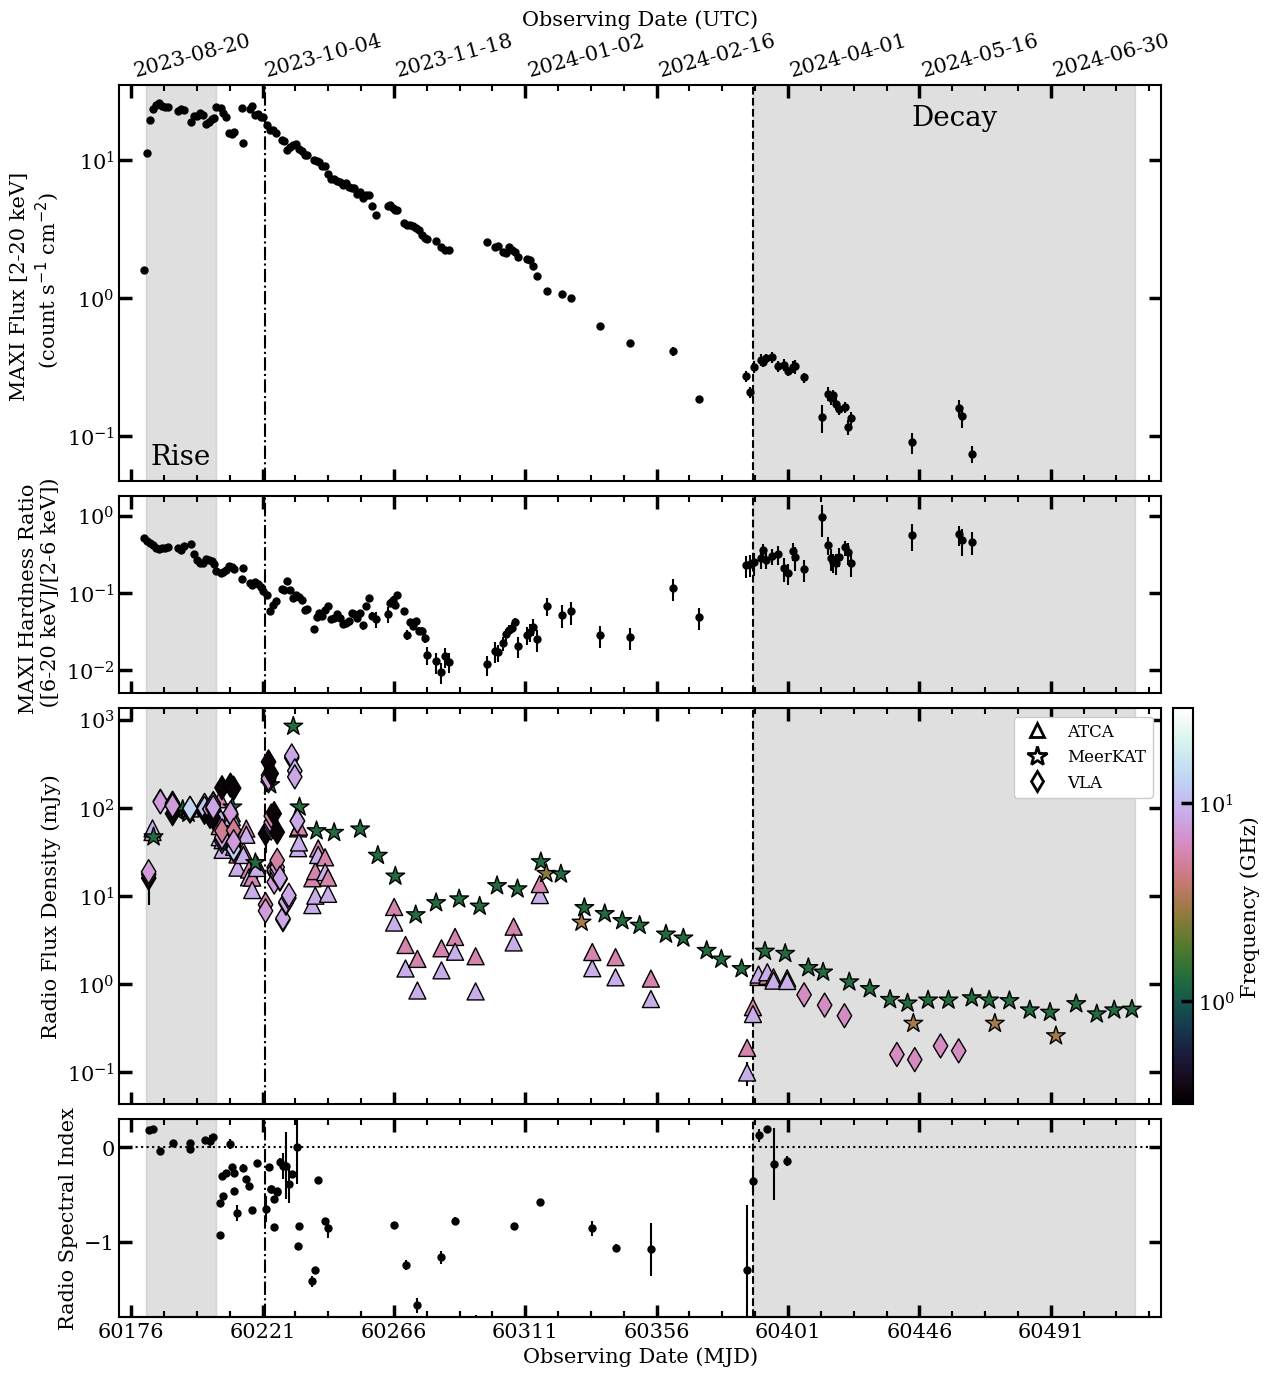

In [3]:
# ------------- #
# Load the Data #
# ------------- #

# Load MAXI/GSC data for X-ray flux and hardness ratio
maxi_data = np.load('SWJ1717_Files/MAXI_HID.npy')

# Load big data from Hughes et al. 2025 (submitted as of 2025 Mar 11)
big_data = pd.read_csv('SWJ1717_Files/SW1717_big_data.csv')
big_data['Midpoint (DT)'] = Time(big_data['Midpoint (MJD)'], format='mjd').datetime  # Convert MJD to datetime

# Load spectral indices for epochs with multi-band observations
big_alpha = np.genfromtxt('SWJ1717_Files/alpha_big_data.txt').T

# From the Hughes et al. 2025 paper, save the rising hard state alpha values (as its single component)
rise_alpha = big_alpha[:, big_alpha[0] < 60205]
np.savetxt('SWJ1717_Files/alpha_core_rise.txt', rise_alpha.T, header='Date (MJD), Spec. Index, Spec. Index Err')

# ------------- #
# Plot the Data #
# ------------- #

# Initialize a 4-panel plot with shared x-axis
fig, ax = plt.subplots(4, figsize=(16, 16), sharex=True, gridspec_kw={'hspace': 0.05, 'height_ratios': [1.0, 0.5, 1.0, 0.5]})
ax = np.atleast_1d(ax)  # Ensure `ax` is always an array

# Plot MAXI light curve (top panel)
ax[0].errorbar(Time(maxi_data[:, 0], format='mjd').datetime, maxi_data[:, 4], yerr=maxi_data[:, 5], fmt='o', mec='k', ecolor='k', color='k', ms=5)

# Plot MAXI hardness ratio (second panel)
ax[1].errorbar(Time(maxi_data[:, 0], format='mjd').datetime, maxi_data[:, 2], yerr=maxi_data[:, 3], fmt='o', mec='k', ecolor='k', color='k', ms=5)

# Define marker styles, sizes, and color map for radio data
symbol = ['o', 's', '^', '*', '<', 'd', '>']
ms = [150, 150, 150, 200, 150, 150, 150]
cm = mpl.colormaps['cubehelix']

# Plot radio flux densities (third panel)
for k, tele in enumerate(np.unique(big_data['Telescope'])):
    index = np.where(big_data['Telescope'] == tele)[0]

    # Only plot VLA, MeerKAT, and ATCA data (used for LrLx analysis)
    if tele in ['VLA', 'MeerKAT', 'ATCA']:
        cplt = ax[2].scatter(big_data['Midpoint (DT)'][index], big_data['Integrated flux (mJy)'][index],
                             c=big_data['Frequency (GHz)'][index], zorder=10000, ec='k', cmap=cm, norm='log',
                             s=ms[k], label=f'{tele}', marker=symbol[k], vmin=0.3, vmax=30.)
        ax[2].errorbar(big_data['Midpoint (DT)'][index], big_data['Integrated flux (mJy)'][index],
                       big_data['Error (mJy)'][index], fmt='.', ecolor='k')

# Plot spectral indices (bottom panel)
ax[3].errorbar(Time(big_alpha[0], format='mjd').datetime, big_alpha[1], big_alpha[2], fmt='o', mec='k', ecolor='k', color='k', ms=5)
ax[3].axhline(0.0, ls=':', c='k')  # Add a horizontal line at 0

# --------------- #
# Format the Plot #
# --------------- #

# Add legend for radio telescopes
legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='ATCA', mec='k', mfc='w', mew=2, markersize=10),
    Line2D([0], [0], marker='*', color='w', label='MeerKAT', mec='k', mfc='w', mew=2, markersize=15),
    Line2D([0], [0], marker='d', color='w', label='VLA', mec='k', mfc='w', mew=2, markersize=10),
]

# Format individual panels
ax[0].set_ylabel('MAXI Flux [2-20 keV] \n (count s$^{-1}$ cm$^{-2}$)', fontfamily='serif')
ax[0].set_yscale('log')

ax[1].set_ylabel('MAXI Hardness Ratio \n ([6-20 keV]/[2-6 keV])', fontfamily='serif')
ax[1].set_yscale('log')

ax[2].legend(handles=legend_elements, fontsize=12, ncol=1, loc='upper right', framealpha=1.0)
ax[2].set_yscale('log')
ax[2].set_ylabel('Radio Flux Density (mJy)')

ax[3].set_ylabel('Radio Spectral Index')
ax[3].tick_params(labelbottom=False)

# Add color bar for radio frequencies
fig.colorbar(cplt, ax=ax[2], label="Frequency (GHz)", shrink=1, pad=0.01)

# Highlight state transitions and hard state times
for ax_i in ax:
    # State transitions from literature
    ax_i.axvline(Time(60389, format='mjd').datetime, ls='--', c='k')  # Soft --> Hard; Atel 16541
    ax_i.axvline(Time(60222, format='mjd').datetime, ls='-.', c='k')  # Hard --> Soft; Atel 16273

    # Highlight hard state times with shaded regions
    ax_i.axvspan(Time(big_data['Midpoint (MJD)'][0] - 1, format='mjd').datetime,
                 Time(big_data['Midpoint (MJD)'][86] - 1, format='mjd').datetime, color='grey', alpha=0.25)
    ax_i.axvspan(Time(60389, format='mjd').datetime,
                 Time(big_data['Midpoint (MJD)'][len(big_data['Midpoint (MJD)']) - 1] + 1, format='mjd').datetime,
                 color='grey', alpha=0.25)

# Write Rise and Decay in the grey regions
ax[0].text(Time(60193,format='mjd').datetime, 7e-2, 'Rise', fontsize=20, ha='center', va='center', color='k')
ax[0].text(Time(60458,format='mjd').datetime, 20, 'Decay', fontsize=20, ha='center', va='center', color='k')

# Format x-axis with UTC on top and MJD on bottom
ax[3].set_ylim(-1.8, 0.3)
FormatAxis(ax, np.array(big_data['Midpoint (MJD)']), interval=45)
align_axis_x(ax[0], ax[2])
align_axis_x(ax[1], ax[2])
align_axis_x(ax[3], ax[2])


# Show and save the plot
plt.savefig('plots/SW1717_LC.pdf', bbox_inches='tight')
plt.show()

## Plot the (hard state) radio and X-ray light curves before any data manipulation

This section presents the raw, unprocessed light curves for Swift J1727.8-1613 during both the rise and decay phases of the hard state, \
providing a direct visual overview of the data prior to any interpolation, subtraction, or other processing steps.


/tmp/ipykernel_259077/892713787.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_xticklabels(xlabels, rotation=15, ha='left')
/tmp/ipykernel_259077/892713787.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, i].set_xticklabels(xlabels, rotation=15, ha='left')


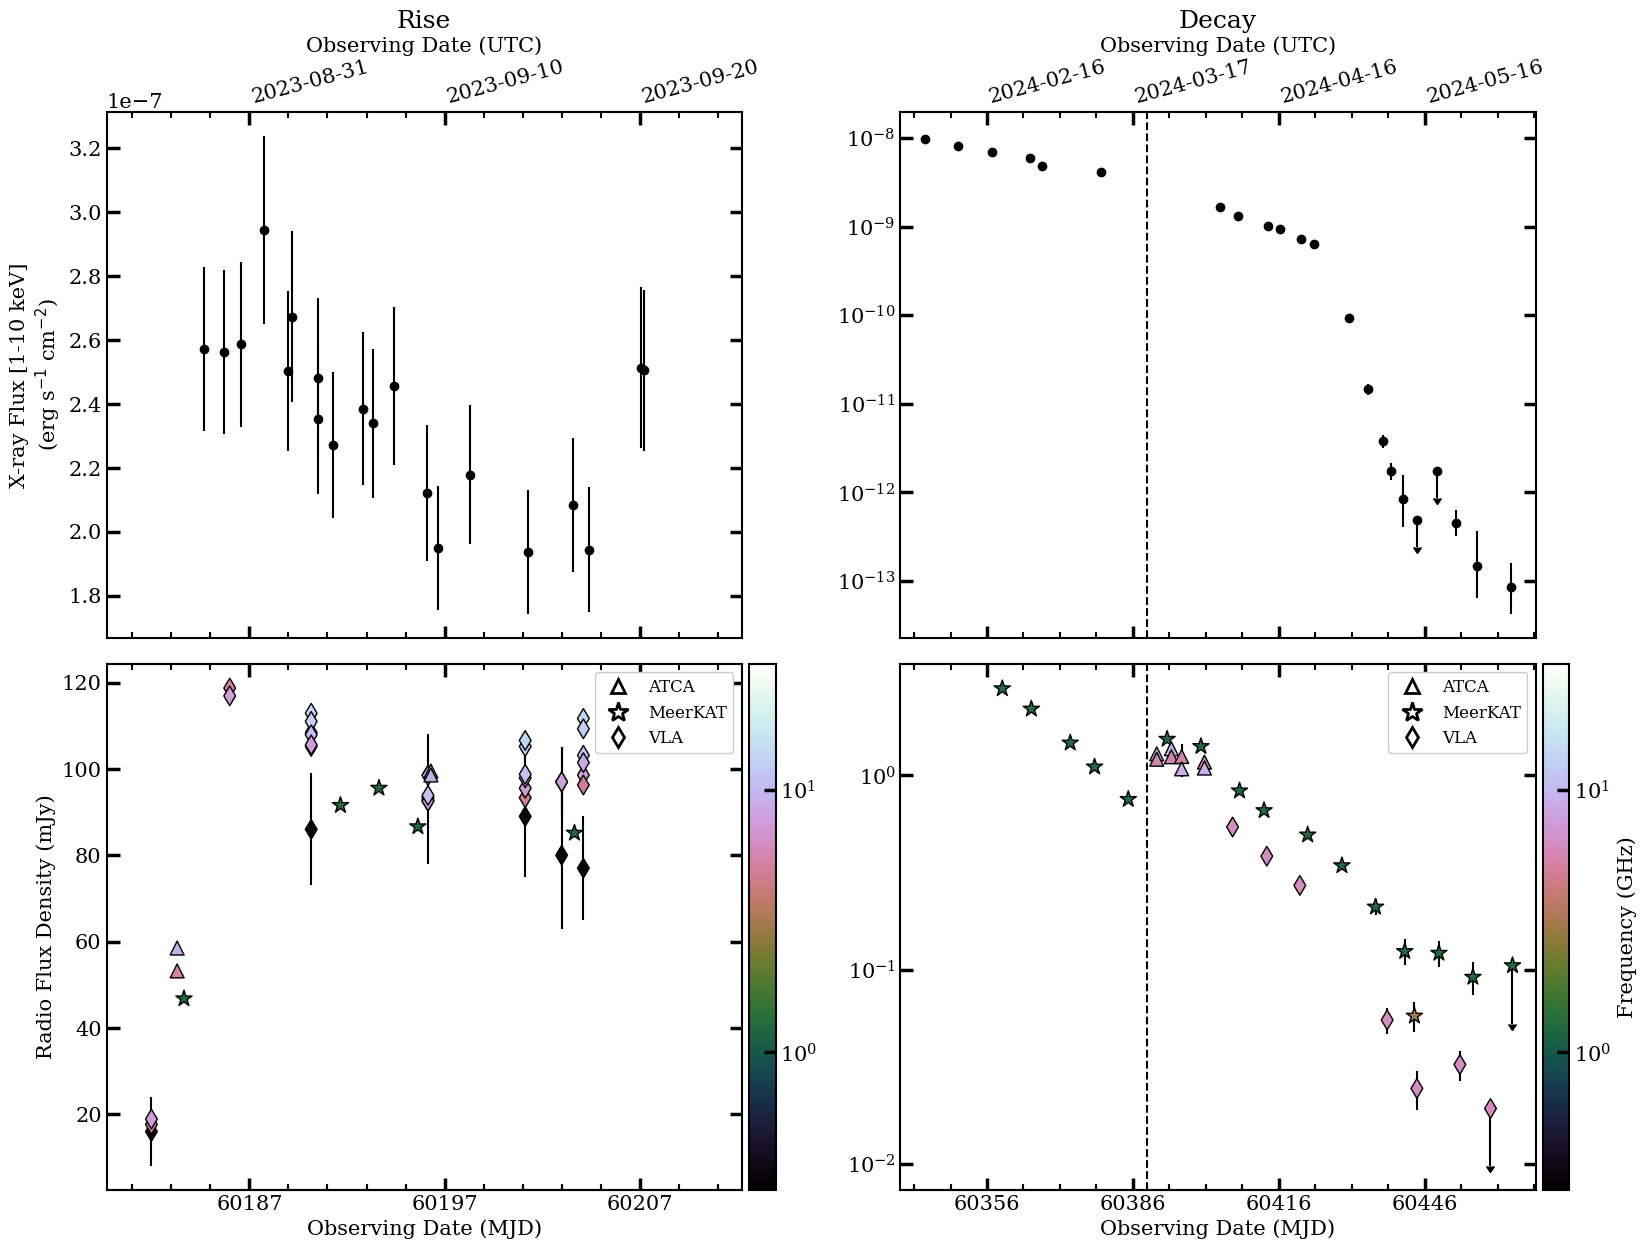

In [4]:
# This Notebook uses rise/decay in place for early/late or bright/faint or initial/final when describing which hard state is which; should be fairly straight forward

# ------------- #
# Load the Data #
# ------------- #

xrt_rise = np.genfromtxt('SWJ1717_Files/XRT_rise.txt', skip_header = 1).T
xrt_decay = np.genfromtxt('SWJ1717_Files/XRT_decay.txt', skip_header = 1).T

mkat_rise = np.genfromtxt('SWJ1717_Files/MeerKAT_core_rise.txt', skip_header = 1).T
mkat_decay = np.genfromtxt('SWJ1717_Files/MeerKAT_core_decay.txt', skip_header = 1).T

vla_rise = np.genfromtxt('SWJ1717_Files/VLA_core_rise.txt', skip_header = 1).T
vla_decay = np.genfromtxt('SWJ1717_Files/VLA_core_decay.txt', skip_header = 1).T

atca_rise = np.genfromtxt('SWJ1717_Files/ATCA_core_rise.txt', skip_header = 1).T
atca_decay = np.genfromtxt('SWJ1717_Files/ATCA_core_decay.txt', skip_header = 1).T

# ------------- #
# Plot the Data #
# ------------- #

# Initialise the plot
fig, ax = plt.subplots(2,2, figsize = (20,14), sharex='col', gridspec_kw={'hspace': 0.05, 'wspace':0.05})

# ----------
# ---- RISE

# MeerKAT 
arr = mkat_rise
sym  = '*'
size = 150 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,0].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)


# VLA 
arr = vla_rise
sym  = 'd'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,0].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)

# ATCA 
arr = atca_rise
sym  = '^'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,0].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)


# ---- XRT - This plots the X-ray flux (not the log10 flux)
arr = xrt_rise
dt = Time(arr[0], format='mjd').datetime
ax[0,0].errorbar(dt, arr[1], yerr = arr[4:6], fmt = 'o', color='k', label = 'Raw')

# ----------
# ---- DECAY

# ---- Radio

# MeerKAT 
arr = mkat_decay
sym  = '*'
size = 150 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,1].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,1].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,1].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,1].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)


# VLA 
arr = vla_decay
sym  = 'd'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,1].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,1].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,1].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,1].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)

# ATCA 
arr = atca_decay
sym  = '^'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[1,1].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Detections
ax[1,1].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1,1].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.) # Upper limits
ax[1,1].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)


# ---- XRT
arr = xrt_decay
dt = Time(arr[0], format='mjd').datetime
ulim = arr[-1].astype(bool)
ax[0,1].errorbar(dt[~ulim], arr[1][~ulim], yerr = arr[4:6,~ulim], fmt = 'o', color='k')
ax[0,1].errorbar(dt[ulim], arr[1][ulim], yerr = arr[1][ulim] * 0.5, mfc = 'k', fmt = 'o', uplims = True, color='k')


# State transition
ax[0,1].axvline(Time(60389, format='mjd').datetime, ls='--', c = 'k') # Soft --> Hard; Atel 16541 
ax[1,1].axvline(Time(60389, format='mjd').datetime, ls='--', c = 'k') # Soft --> Hard; Atel 16541 


# --------------- #
# Format the Plot #
# --------------- #

# Labelling
ax[1,0].set_ylabel('Radio Flux Density (mJy)')
ax[0,0].set_ylabel('X-ray Flux [1-10 keV]\n(erg s$^{-1}$ cm$^{-2}$)')
ax[0,0].set_title('Rise')
ax[0,1].set_title('Decay')

ax[1,0].legend(handles=legend_elements, fontsize=12, ncol=1, loc = 'upper right', framealpha = 1.0)
ax[1,1].legend(handles=legend_elements, fontsize=12, ncol=1, loc = 'upper right', framealpha = 1.0)


# Set the Scaling
ax[1,1].set_yscale('log')
ax[0,1].set_yscale('log')

# Include MJD (bottom) and Datetime (top)
ax[1,1].tick_params(labelbottom = False)
ax[1,0].tick_params(labelbottom = False)
FormatAxis(ax, [xrt_rise[0], xrt_decay[0]], dt = [5,5], interval= [10, 30])

# Colour bar formatting
fig.colorbar(cplt, ax=ax[1,0], shrink = 1, pad = 0.01)
fig.colorbar(cplt, ax=ax[1,1], shrink = 1, pad = 0.01, label="Frequency (GHz)")
align_axis_x(ax[0,0], ax[1,0])
align_axis_x(ax[0,1], ax[1,1])
plt.show()

## Simple Two-Point Linear Interpolation with Error Propagation

This section defines a function to perform two-point linear interpolation on data with (Gaussian) uncertainties, supporting both symmetric and asymmetric errors. \
The function can interpolate in linear, natural logarithmic, or log10 space, and propagates uncertainties following White (2017).

**Key features:**
- Handles both symmetric and asymmetric error bars.
- Supports interpolation in linear, log, or log10 space (the latter is useful for X-ray data).
- Returns both interpolated values and propagated uncertainties.
- Excludes extrapolation outside the input data range.
- Reference: [White 2017, International Journal of Thermophysics, 38, 119](https://link.springer.com/article/10.1007/s10765-016-2174-6)

This function is used throughout the notebook to interpolate X-ray and radio fluxes onto common time grids for further analysis.

In [5]:
def two_point_linear_interpolation(xnew, data, method='linear'):
    """
    Perform two-point linear interpolation on a dataset with optional error propagation.

    This function takes in a dataset `data` containing x-values, y-values, and their associated 
    uncertainties (symmetric or asymmetric) and interpolates onto a new set of x-values (`xnew`). 
    The interpolation can be performed in either linear, logarithmic, or log10-linear space.

    The `linlog` method is specifically tailored for X-ray data where the input y-values are already 
    in log10 space. This method accounts for the asymmetry of X-ray error bars and returns both 
    interpolated log10 values and their corresponding linear-space values.

    Reference:
    - White 2017 (https://link.springer.com/article/10.1007/s10765-016-2174-6)

    Parameters:
    - xnew (array-like): The new x-values to interpolate onto.
    - data (array-like): The input data in the format:
        [x, y, dy] for symmetric errors or [x, y, dy_neg, dy_pos] for asymmetric errors.
        Shape: (3, N) or (4, N), where N is the number of data points.
        - For the `linlog` method, `y` should already be in log10 space.
    - method (str): The interpolation method, one of:
        - 'linear': Perform interpolation in linear space.
        - 'log': Perform interpolation in natural logarithmic space.
        - 'linlog': Perform interpolation in log10 space and return both log10 and linear-space values.

    Returns:
    - np.ndarray: Interpolated data in the format:
        - For 'linear' or 'log':
            [xnew, ynew, dynew_neg, dynew_pos, ulim] for asymmetric errors, or
            [xnew, ynew, dynew, ulim] for symmetric errors.
        - For 'linlog':
            Two arrays:
            1. Log10 flux: [xnew, ynew, dynew_neg, dynew_pos, ulim].
            2. Linear flux: [xnew, ylin, dylin_neg, dylin_pos, ulim].
        - xnew: Interpolated x-values.
        - ynew: Interpolated y-values (log10 or linear).
        - dynew_neg/dynew: Lower bound of the interpolated uncertainties.
        - dynew_pos: Upper bound of the interpolated uncertainties (for asymmetric errors).
        - ulim: Array of zeros indicating no upper limits.

    Raises:
    - TypeError: If input data is not a list or NumPy array.
    - TypeError: If input data does not have 3 or 4 rows.
    - TypeError: If the interpolation method is not 'linear', 'log', or 'linlog'.

    Notes:
    - If any values in `xnew` fall outside the range of `data[0]`, they are excluded.
    - The function enforces sorting of both `xnew` and `data` to ensure proper interpolation.
    - Uncertainties are propagated using the method described in White 2017 (Eq. 15).
    - The `linlog` method assumes the input y-values are already in log10 space.
    """

    # Ensure xnew is at least 1D
    xnew = np.atleast_1d(xnew)

    # Validate the input data type
    if isinstance(data, list):
        data = np.array(data)
    elif not isinstance(data, np.ndarray):
        raise TypeError('Input data should be a list or NumPy array.')

    # Validate the dimensions of the input data
    if data.shape[0] not in [3, 4]:
        raise TypeError('Input data should have 3 rows (symmetric errors) or 4 rows (asymmetric errors).')

    # Validate the interpolation method
    if method not in ['linear', 'log', 'linlog']:
        raise TypeError('Interpolation method must be either "linear", "log", or "linlog".')

    # Remove xnew values outside the range of data[0]
    valid_indices = (xnew >= data[0].min()) & (xnew <= data[0].max())
    xnew = xnew[valid_indices]

    # Sort xnew and data to ensure proper interpolation
    xnew = np.sort(xnew)
    data = data[:, data[0].argsort()]

    # Find the indices of the bounding points for each xnew
    hi = np.searchsorted(data[0], xnew)
    lo = hi - 1

    # Transform to natural logarithmic space if required
    if method == 'log':
        data[2:] = np.abs(data[2:] / data[1])  # Convert errors to fractional uncertainties
        data[1] = np.log(data[1])  # Take the natural logarithm of y-values

    # Perform linear interpolation (White 2017, Eq. 14)
    ynew = (
        data[1, lo] * (xnew - data[0, hi]) / (data[0, lo] - data[0, hi]) +  # L1 term
        data[1, hi] * (xnew - data[0, lo]) / (data[0, hi] - data[0, lo])    # L2 term
    )

    # Propagate uncertainties (White 2017, Eq. 15)
    dynew = (
        ((xnew - data[0, hi]) / (data[0, lo] - data[0, hi]) * data[2:, lo]) ** 2 +
        ((xnew - data[0, lo]) / (data[0, hi] - data[0, lo]) * data[2:, hi]) ** 2
    ) ** 0.5

    # Initialize upper limit array (all zeros, indicating no upper limits)
    ulim = np.zeros_like(ynew)

    # Handle the 'linlog' method
    if method == 'linlog':
        # Convert log10 interpolated values to linear space
        ylin = 10 ** ynew

        # Calculate linear-space errors using differences (to handle asymmetry)
        if data.shape[0] == 4:  # Asymmetric errors
            dylin = np.array([
                10 ** ynew - 10 ** (ynew - dynew[0]),  # Lower bound
                10 ** (ynew + dynew[1]) - 10 ** ynew   # Upper bound
            ])
        else:  # Symmetric errors
            dylin = np.array([10 ** ynew - 10 ** (ynew - dynew[0])])

        # Return both log10 and linear-space interpolated data
        return np.array([xnew, ynew, dynew[0], dynew[1], ulim]), np.array([xnew, ylin, dylin[0], dylin[1], ulim])

    # Convert back to linear space if interpolation was performed in natural log space
    if method == 'log':
        ynew = np.exp(ynew)
        dynew = ynew * dynew  # Scale uncertainties back to linear space

    # Return the interpolated data
    if dynew.shape[0] > 1:  # Asymmetric errors
        return np.array([xnew, ynew, dynew[0], dynew[1], ulim])
    else:  # Symmetric errors
        return np.array([xnew, ynew, dynew[0], ulim])

## Interpolate X-ray onto Radio Times

This step interpolates the X-ray data onto the times of the radio observations and saves the intermediate data products for further analysis.

**Output files:**
1. `XRT_rise_interp.txt`
2. `XRT_decay_interp.txt`

In [6]:
# Define a function to handle rise and decay interpolation
# Define a function to handle rise and decay interpolation
def interpolate_and_save(xrt_data, radio_times, output_file, header, method='log'):
    """
    Interpolate X-ray data onto radio observation times and save the results.

    Parameters:
    - xrt_data (np.ndarray): X-ray data array with columns [MJD, Flux, Sys Err neg, Sys Err pos, Upper Limit].
    - radio_times (list or np.ndarray): Radio observation times to interpolate onto.
    - output_file (str): Base path to save the interpolated data. For 'linlog', two files will be created.
    - header (str): Header for the output text file.
    - method (str): Interpolation method ('linear', 'log', or 'linlog').
    """
    # Concatenate and sort unique radio observation times
    xnew = np.sort(np.unique(np.concatenate(radio_times)))

    # Exclude upper limits from the X-ray data
    ulim = xrt_data[-1].astype(bool)
    data = xrt_data[:, ~ulim]
    data = data[[0, 6, 9, 10], :]  # Select MJD, logflux, log Sys Err neg, log Sys Err pos

    # Perform interpolation
    if method == 'linlog':
        # For 'linlog', get both log10 and linear flux interpolations
        log_flux, lin_flux = two_point_linear_interpolation(xnew, data, method=method)

        # Save log10 flux data
        np.savetxt(
            output_file.replace('.txt', '_log.txt'),
            np.array([log_flux[0], log_flux[1], log_flux[2], log_flux[3], log_flux[4]]).T,
            header=header.replace('Flux', 'Log10 Flux').replace('erg s^-1 cm^-2','')
        )

        # Save linear flux data
        np.savetxt(
            output_file.replace('.txt', '_lin.txt'),
            np.array([lin_flux[0], lin_flux[1], lin_flux[2], lin_flux[3], lin_flux[4]]).T,
            header=header
        )
    else:
        # For 'linear' or 'log', perform standard interpolation and save the result
        ynew = two_point_linear_interpolation(xnew, data, method=method)
        np.savetxt(
            output_file,
            np.array([ynew[0], ynew[1], ynew[2], ynew[3], ynew[4]]).T,
            header=header
        )
# ----------
# ---- RISE
interpolate_and_save(
    xrt_data=xrt_rise,
    radio_times=[mkat_rise[0], vla_rise[0], atca_rise[0]],
    output_file='SWJ1717_Files/XRT_rise_interp.txt',
    method = 'linlog',
    header='Date (MJD), Flux (erg s^-1 cm^-2), Sys Err neg (erg s^-1 cm^-2), Sys Err pos (erg s^-1 cm^-2), Upper Limit (True - 1, False - 0)'
)

# ----------
# ---- DECAY
interpolate_and_save(
    xrt_data=xrt_decay,
    radio_times=[mkat_decay[0, 5:], vla_decay[0], atca_decay[0]],
    output_file='SWJ1717_Files/XRT_decay_interp.txt',
    method = 'linlog',
    header='Date (MJD), Flux (erg s^-1 cm^-2), Sys Err neg (erg s^-1 cm^-2), Sys Err pos (erg s^-1 cm^-2), Upper Limit (True - 1, False - 0)'
)

## Plot the interpolated data

/tmp/ipykernel_259077/3518108939.py:116: UserWarning: Adding colorbar to a different Figure <Figure size 2000x1400 with 6 Axes> than <Figure size 1000x800 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(cplt, ax=ax[1], shrink=1, pad=0.01, label="Frequency (GHz)")
/tmp/ipykernel_259077/892713787.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


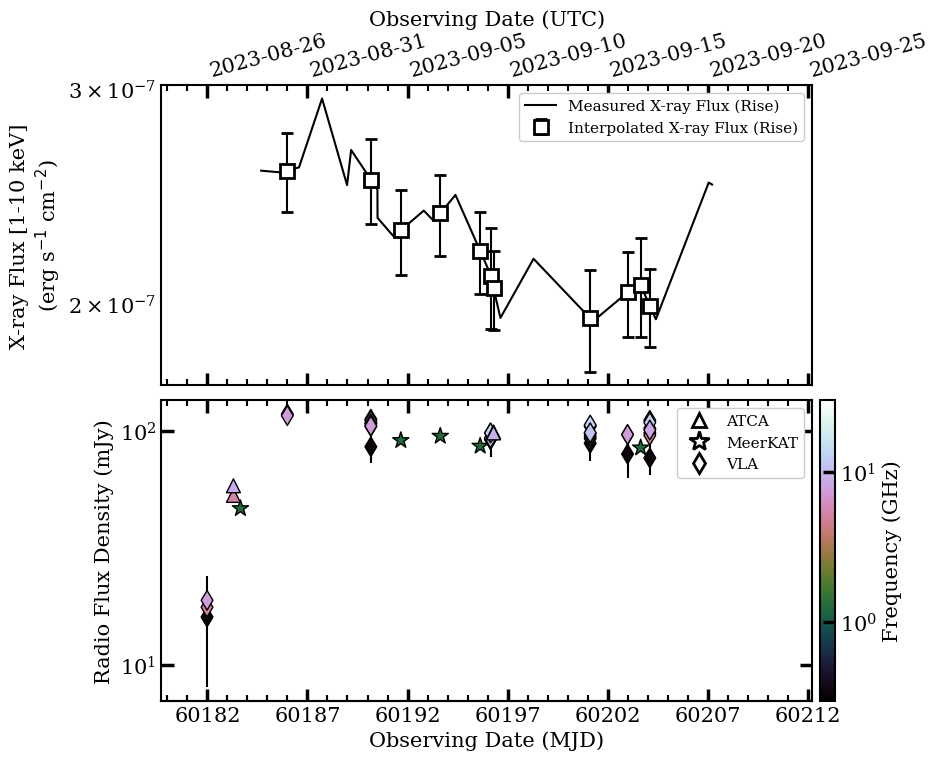

/tmp/ipykernel_259077/3518108939.py:140: UserWarning: Adding colorbar to a different Figure <Figure size 2000x1400 with 6 Axes> than <Figure size 1000x800 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(cplt, ax=ax[1], shrink=1, pad=0.01, label="Frequency (GHz)")
/tmp/ipykernel_259077/892713787.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


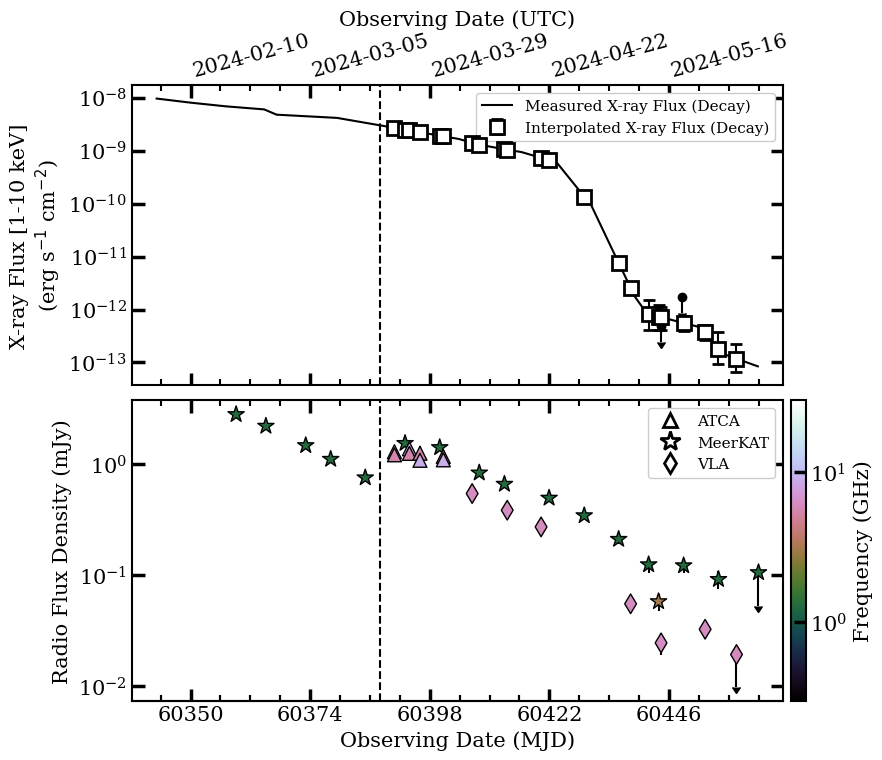

In [7]:
# ---------------- #
# Load the Data #
# ---------------- #

# Load X-ray data for rise and decay phases
xrt_rise = np.genfromtxt('SWJ1717_Files/XRT_rise.txt', skip_header=1).T  # Raw X-ray data (rise)
xrt_rise_interp = np.genfromtxt('SWJ1717_Files/XRT_rise_interp_lin.txt', skip_header=1).T  # Interpolated X-ray data (rise)
xrt_decay = np.genfromtxt('SWJ1717_Files/XRT_decay.txt', skip_header=1).T  # Raw X-ray data (decay)
xrt_decay_interp = np.genfromtxt('SWJ1717_Files/XRT_decay_interp_lin.txt', skip_header=1).T  # Interpolated X-ray data (decay)

# Load radio data for rise and decay phases
mkat_rise = np.genfromtxt('SWJ1717_Files/MeerKAT_core_rise.txt', skip_header=1).T
mkat_decay = np.genfromtxt('SWJ1717_Files/MeerKAT_core_decay.txt', skip_header=1).T
vla_rise = np.genfromtxt('SWJ1717_Files/VLA_core_rise.txt', skip_header=1).T
vla_decay = np.genfromtxt('SWJ1717_Files/VLA_core_decay.txt', skip_header=1).T
atca_rise = np.genfromtxt('SWJ1717_Files/ATCA_core_rise.txt', skip_header=1).T
atca_decay = np.genfromtxt('SWJ1717_Files/ATCA_core_decay.txt', skip_header=1).T

# ---------------- #
# Helper Functions #
# ---------------- #

def plot_xray(ax, xrt_data, xrt_interp, phase_label):
    """
    Plot X-ray data (raw and interpolated) for a given phase.

    Parameters:
    - ax (matplotlib.axes.Axes): Axes to plot on.
    - xrt_data (np.ndarray): Raw X-ray data.
    - xrt_interp (np.ndarray): Interpolated X-ray data.
    - phase_label (str): Label for the phase (e.g., 'Rise', 'Decay').
    """
    # Plot interpolated X-ray data
    arr = xrt_interp
    dt = Time(arr[0], format='mjd').datetime
    ax.errorbar(
        dt, arr[1], yerr=arr[2:4], fmt='s', color='k', mfc='w', ms=10,
        label=f'Interpolated X-ray Flux ({phase_label})', zorder=10000, mew=2, capsize=4
    )

    # Plot raw X-ray data
    arr = xrt_data
    dt = Time(arr[0], format='mjd').datetime
    ulim = arr[-1].astype(bool)
    ax.plot(dt[~ulim], arr[1][~ulim], ls='-', color='k', label=f'Measured X-ray Flux ({phase_label})')
    ax.errorbar(
        dt[ulim], arr[1][ulim], yerr=arr[1][ulim] * 0.5, mfc='k', fmt='o', uplims=True, color='k'
    )


def plot_radio(ax, radio_data, labels, symbols, sizes):
    """
    Plot radio data for multiple telescopes.

    Parameters:
    - ax (matplotlib.axes.Axes): Axes to plot on.
    - radio_data (list of np.ndarray): List of radio data arrays for different telescopes.
    - labels (list of str): Labels for the telescopes.
    - symbols (list of str): Marker symbols for the telescopes.
    - sizes (list of int): Marker sizes for the telescopes.
    """
    for arr, sym, size, label in zip(radio_data, symbols, sizes, labels):
        ulim = arr[-1].astype(bool)
        dt = Time(arr[0], format='mjd').datetime
        cplt = ax.scatter(
            dt[~ulim], arr[1][~ulim], c=arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm='log',
            s=size, marker=sym, vmin=0.3, vmax=30., label=label
        )  # Detections
        ax.errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt='.', ecolor='k')
        ax.scatter(
            dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c=arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm='log',
            s=size, marker=sym, vmin=0.3, vmax=30.
        )  # Upper limits
        ax.errorbar(
            dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]),
            fmt='.', ecolor='k', uplims=True
        )


def setup_plot(ax, ylabel, legend_elements=None):
    """
    Set up the plot with labels, legends, and scaling.

    Parameters:
    - ax (list of matplotlib.axes.Axes): List of axes to configure.
    - ylabel (str): Label for the y-axis.
    - legend_elements (list, optional): Custom legend elements for the plot.
    """
    ax[1].set_ylabel('Radio Flux Density (mJy)')
    ax[0].set_ylabel(ylabel)
    ax[1].legend(handles=legend_elements, fontsize=11, ncol=1, loc='upper right', framealpha=1.0)
    ax[0].legend(fontsize=11, ncol=1, loc='upper right', framealpha=1.0)
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[1].tick_params(labelbottom=False)


# ---------------- #
# Plot the Rise Data #
# ---------------- #

# Initialize the plot for the rise phase
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'hspace': 0.05})

# Plot X-ray and radio data for the rise phase
plot_xray(ax[0], xrt_rise, xrt_rise_interp, 'Rise')
plot_radio(ax[1], [mkat_rise, vla_rise, atca_rise], ['MeerKAT', 'VLA', 'ATCA'], ['*', 'd', '^'], [150, 100, 100])

# Add labels, legends, and color bar
legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='ATCA', mec='k', mfc='w', mew=2, markersize=10),
    Line2D([0], [0], marker='*', color='w', label='MeerKAT', mec='k', mfc='w', mew=2, markersize=15),
    Line2D([0], [0], marker='d', color='w', label='VLA', mec='k', mfc='w', mew=2, markersize=10),
]
setup_plot(ax, 'X-ray Flux [1-10 keV]\n(erg s$^{-1}$ cm$^{-2}$)', legend_elements)
fig.colorbar(cplt, ax=ax[1], shrink=1, pad=0.01, label="Frequency (GHz)")

# Format and align axes
FormatAxis(ax, xrt_rise[0], dt=5, interval=5)
align_axis_x(ax[0], ax[1])

# Save and show the rise plot
plt.savefig('plots/SWJ1717_Interp_Rise.pdf', bbox_inches='tight')
plt.show()


# ---------------- #
# Plot the Decay Data #
# ---------------- #

# Initialize the plot for the decay phase
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'hspace': 0.05})

# Plot X-ray and radio data for the decay phase
plot_xray(ax[0], xrt_decay, xrt_decay_interp, 'Decay')
plot_radio(ax[1], [mkat_decay, vla_decay, atca_decay], ['MeerKAT', 'VLA', 'ATCA'], ['*', 'd', '^'], [150, 100, 100])

# Add labels, legends, and color bar
setup_plot(ax, 'X-ray Flux [1-10 keV]\n(erg s$^{-1}$ cm$^{-2}$)', legend_elements)
fig.colorbar(cplt, ax=ax[1], shrink=1, pad=0.01, label="Frequency (GHz)")

# Highlight the soft-to-hard state transition (decay only)
transition_date = Time(60388, format='mjd').datetime
ax[0].axvline(transition_date, ls='--', c='k')
ax[1].axvline(transition_date, ls='--', c='k')

# Format and align axes
FormatAxis(ax, xrt_decay[0], dt=5, interval=24)
align_axis_x(ax[0], ax[1])

# Save and show the decay plot
plt.savefig('plots/SWJ1717_Interp_Decay.pdf', bbox_inches='tight')
plt.show()

## Solve for Exponential Decay During the Soft State and Subtract From Core Flux Density

#### Save Decay-Subtracted Flux

By default, the decay is modeled as an exponential.  
To use a power-law decay instead, uncomment the highlighted code below.

**Output filenames:**
1. `ATCA_core_decay_sub.txt`
2. `MeerKAT_core_decay_sub.txt`
3. `VLA_core_decay_sub.txt`

Fit Parameters are:  [ 2.84349067 20.45620044] +/- [0.05532365 0.83560851]


/tmp/ipykernel_259077/892713787.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


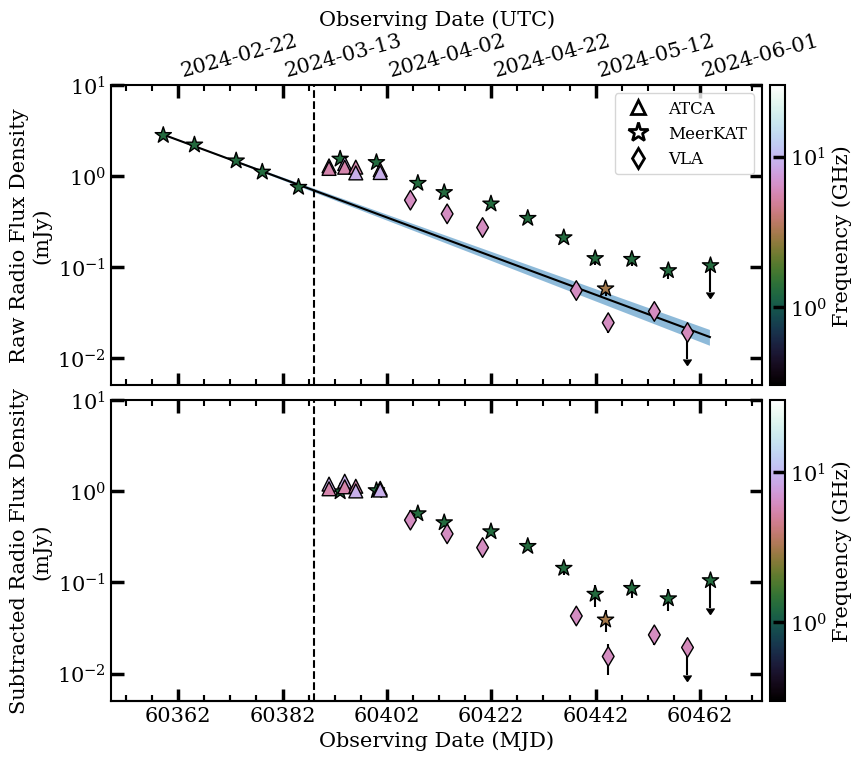

In [8]:
# --------------------------- #
# Solve for Exponential Decay #
# --------------------------- #

def mod_decay(x, A, tau):
    '''
    Exponential decay model.

    Parameters:
    - x (array): Time values (e.g., MJD).
    - A (float): Initial amplitude of the decay.
    - tau (float): Decay timescale.

    Returns:
    - array: Exponential decay values at each time point.
    '''
    return A * np.exp(-1. * (x - mkat_decay[0,0]) / tau)

# UNCOMMENT THIS FOR POWERLAW DECAY
# def mod_decay(x, A, tau):
#     '''
#     Powerlaw decay model.

#     Parameters:
#     - x (array): Time values (e.g., MJD).
#     - A (float): Initial amplitude of the decay.
#     - tau (float): powerlaw index.

#     Returns:
#     - array: powerlaw decay values at each time point.
#     '''
#     return A * (x / mkat_decay[0,0]) ** tau

# Adapted from: https://stackoverflow.com/questions/79028892/how-to-get-errors-on-a-cubic-spline-interpolation-python-splrep-splev
def variance(model, x, p, Cp):
    '''
    Compute the variance of a model fit using the covariance matrix.

    Parameters:
    - model (function): The model function.
    - x (array): Input data points.
    - p (array): Best-fit parameters.
    - Cp (array): Covariance matrix of the fit.

    Returns:
    - array: Standard deviation (sigma) of the model predictions.
    '''
    def proxy(q):
        return model(x, *q)

    def projection(J):
        return J @ Cp @ J.T

    Jp = nd.Jacobian(proxy)(p)  # Compute the Jacobian
    Cy = np.apply_along_axis(projection, 1, Jp)

    # Return square root to get sigma
    return Cy ** 0.5


# --------------------------- #
# Fit Exponential Decay Model #
# --------------------------- #

# Extract data for fitting
x = mkat_decay[0, :5]  # Time values (MJD)
y = mkat_decay[1, :5]  # Flux density values (mJy)
dy = mkat_decay[2, :5]  # Flux density uncertainties (mJy)
xmod = np.linspace(mkat_decay[0].min(), mkat_decay[0].max(), 1000)  # Fine-grained time values for plotting

# Fit the exponential decay model
# Note: absolute_sigma=False scales errors conservatively based on relative values
popt, pcov = curve_fit(mod_decay, x, y, sigma=dy, absolute_sigma=False, p0=(7, 20))
# popt, pcov = curve_fit(mod_decay, x, y, sigma=dy, absolute_sigma=False, p0=(3, -3000)) # UNCOMMENT THIS FOR POWERLAW DECAY

print('Fit Parameters are: ', popt, '+/-', np.sqrt(np.diag(pcov)))

# Compute confidence intervals for the fit
sigmamod = variance(mod_decay, xmod, popt, pcov)

# -------------------------------------------------- #
# Scale and Subtract Decay from Each Radio Telescope #
# -------------------------------------------------- #

# Make copies of the arrays for subtraction
mkat_sub = mkat_decay.copy()
vla_sub = vla_decay.copy()
atca_sub = atca_decay.copy()

# Subtract the exponential decay and propagate errors
# Exclude upper limits from subtraction (conservative assumption)
alpha_ejecta = -1.0

# MeerKAT
ulim = mkat_sub[-1].astype(bool)  # Identify upper limits
mkat_sub[1, ~ulim] -= mod_decay(mkat_sub[0, ~ulim], *popt) * (mkat_sub[-2, ~ulim] / 1.28) ** alpha_ejecta
mkat_sub[2, ~ulim] = np.sqrt(
    mkat_sub[2, ~ulim] ** 2 +
    (variance(mod_decay, mkat_sub[0, ~ulim], popt, pcov) * (mkat_sub[-2, ~ulim] / 1.28) ** alpha_ejecta) ** 2
)

# ATCA
ulim = atca_sub[-1].astype(bool)
atca_sub[1, ~ulim] -= mod_decay(atca_sub[0, ~ulim], *popt) * (atca_sub[-2, ~ulim] / 1.28) ** alpha_ejecta
atca_sub[2, ~ulim] = np.sqrt(
    atca_sub[2, ~ulim] ** 2 +
    (variance(mod_decay, atca_sub[0, ~ulim], popt, pcov) * (atca_sub[-2, ~ulim] / 1.28) ** alpha_ejecta) ** 2
)

# VLA
ulim = vla_sub[-1].astype(bool)
vla_sub[1, ~ulim] -= mod_decay(vla_sub[0, ~ulim], *popt) * (vla_sub[-2, ~ulim] / 1.28) ** alpha_ejecta
vla_sub[2, ~ulim] = np.sqrt(
    vla_sub[2, ~ulim] ** 2 +
    (variance(mod_decay, vla_sub[0, ~ulim], popt, pcov) * (vla_sub[-2, ~ulim] / 1.28) ** alpha_ejecta) ** 2
)

# -------------------------------- #
# Save the Subtracted Light Curves #
# -------------------------------- #

np.savetxt('SWJ1717_Files/ATCA_core_decay_sub.txt', atca_sub.T, header='Date (MJD), Peak (mJy), RMS (mJy), Freq (GHz), Upper Limit (True - 1, False - 0)')
np.savetxt('SWJ1717_Files/MeerKAT_core_decay_sub.txt', mkat_sub.T, header='Date (MJD), Peak (mJy), RMS (mJy), Freq (GHz), Upper Limit (True - 1, False - 0)')
np.savetxt('SWJ1717_Files/VLA_core_decay_sub.txt', vla_sub.T, header='Date (MJD), Peak (mJy), RMS (mJy), Freq (GHz), Upper Limit (True - 1, False - 0)')

# ------------------------------------------------ #
# Plot Exponential Fit and Subtracted Light Curves #
# ------------------------------------------------ #

# Initialize the plot
fig, ax = plt.subplots(2, figsize=(10, 8), sharex='col', gridspec_kw={'hspace': 0.05})

# Plot the exponential fit
ax[0].plot(Time(xmod, format='mjd').datetime, mod_decay(xmod, *popt), ls='-', c='k', zorder=10000, label='Exponential Fit')
ax[0].fill_between(
    Time(xmod, format='mjd').datetime,
    mod_decay(xmod, *popt) - sigmamod,
    mod_decay(xmod, *popt) + sigmamod,
    alpha=0.5,
    label=r"68% Confidence Interval"
)


# ---- MeerKAT
arr = mkat_decay
sym  = '*'
size = 150 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[0].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)

# ---- ATCA
arr = atca_decay
sym  = '^'
size = 100 
dt = Time(arr[0], format='mjd').datetime

cplt = ax[0].scatter(dt, arr[1], c = arr[-2], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[0].errorbar(dt, arr[1], arr[2], fmt = '.', ecolor='k')

# ---- VLA
arr = vla_decay
sym  = 'd'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime

cplt = ax[0].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', uplims=True)


# -------------------------------------------------------------------------------------------------------------------------------------------
# Subtracted DATA

# ---- MeerKAT
arr = mkat_sub
sym  = '*'
size = 150 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime
cplt = ax[1].scatter(dt[~ulim][5:], arr[1][~ulim][5:], c = arr[-2][~ulim][5:], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[1].errorbar(dt[~ulim][5:], arr[1][~ulim][5:], arr[2][~ulim][5:], fmt = '.', ecolor='k')

cplt = ax[1].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[1].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', c ='k', uplims=True)

# ---- ATCA
arr = atca_sub
sym  = '^'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime
cplt = ax[1].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[1].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

# ---- VLA
arr = vla_sub
sym  = 'd'
size = 100 
ulim = arr[-1].astype(bool)
dt = Time(arr[0], format='mjd').datetime
cplt = ax[1].scatter(dt[~ulim], arr[1][~ulim], c = arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[1].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt = '.', ecolor='k')

cplt = ax[1].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c = arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm = 'log', s = size, marker=sym, vmin=0.3, vmax=30.)
ax[1].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt = '.', ecolor='k', c ='k', uplims=True)


# ---------- # 
# Formatting #
# ---------- #

for ax_i in ax:
    ax_i.axvline(Time(60388, format='mjd').datetime, ls='--', c = 'k') # Soft --> Hard; Atel 16541 

ax[0].set_yscale('log')
ax[0].set_ylim(5e-3, 10)
ax[0].legend(handles=legend_elements, fontsize=12, ncol=1)

ax[1].set_yscale('log')
ax[1].set_ylim(5e-3, 10)

ax[0].set_ylabel('Raw Radio Flux Density\n(mJy)')
ax[1].set_ylabel('Subtracted Radio Flux Density\n(mJy)')


fig.colorbar(cplt, ax=ax[0], label="Frequency (GHz)", shrink = 1, pad = 0.01)
fig.colorbar(cplt, ax=ax[1], label="Frequency (GHz)", shrink = 1, pad = 0.01)
align_axis_x(ax[1], ax[0])
ax[-1].tick_params(labelbottom = False)
FormatAxis(ax, [mkat_decay[0,0], mkat_decay[0,-1]], interval= 20)
plt.savefig('plots/SWJ1717_Exponential_Decay.pdf',bbox_inches='tight')
plt.show()


## Combine X-ray and Radio Fluxes into Unified Data Files

The following files contain combined, observatory-independent, and outburst phase-dependent flux measurements:

- **X-ray flux:** `Xray_flux.txt`
- **Radio flux:** `radio_flux.txt`

In [10]:
# Re-load the X-ray data
xrt_decay_interp = np.genfromtxt('SWJ1717_Files/XRT_decay_interp_lin.txt', skip_header=1).T  # Interpolated X-ray data (decay)
xrt_rise_interp = np.genfromtxt('SWJ1717_Files/XRT_rise_interp_lin.txt', skip_header=1).T  # Interpolated X-ray data (rise)

# Stack the radio data, then sort it by time:

# Indices will be:
# ---- 0: Time (MJD)
# ---- 1: Flux Density (mJy)
# ---- 2: Flux Density Err (mJy)
# ---- 3: Flux Density Err (mJy - duplicate to match X-rays)
# ---- 4: Freq (GHz)
# ---- 5: Uplim? (Bool)

radio = np.hstack((mkat_rise, mkat_sub, vla_rise, vla_sub, atca_rise, atca_sub))
radio = radio[:, radio[0].argsort()] 
radio = np.array(radio[:3].tolist() + radio[2:].tolist())

# Add in a systematic on the radio flux error
f_sys = 0.1
radio[2:4] = (radio[2:4] ** 2 + (f_sys * radio[1]) ** 2) ** 0.5

# Stack the X-ray data, then sort it by time:

# Indices will be:
# ---- 0: Time (MJD)
# ---- 1: Flux (erg / cm^2 / s^-1)
# ---- 2: Flux Err Neg (erg / cm^2 / s^-1)
# ---- 3: Flux Err Pos (erg / cm^2 / s^-1)
# ---- 4: Uplim? (Bool)


# Stack and sort
xray = np.hstack((xrt_rise_interp, xrt_decay_interp))
xray = xray[:, xray[0].argsort()] 

# Make sure there is one-to-one mapping in time
radio = radio[:, np.isin(radio[0], xray[0])]

# Save the arrays
if len(np.unique(radio[0])) == len(xray[0]):
    np.savetxt('SWJ1717_Files/Xray_flux.txt', xray.T, header='Date (MJD), Flux (erg/cm^2/s), Flux Err neg (erg/cm^2/s), Flux Err pos (erg/cm^2/s), Upper Limit (True - 1, False - 0)')
    np.savetxt('SWJ1717_Files/radio_flux.txt', radio.T, header='Date (MJD), Flux Density (mJy), Flux Density Err (mJy), Flux Density Err (mJy), Freq (GHz), Upper Limit (True - 1, False - 0)')

else:
    print('The times are not matching; check the data!')

## Calculate the Radio Spectral Indices During the Decay

### Saved Spectral Index Files

**File names:**

1. `alpha_core_rise.txt`
2. `alpha_core_decay.txt`
3. `alpha_core.txt`

[60390.90653935 60393.91284722 60396.03165509 60400.71493056]
[ 0.2403972   0.28734734 -0.24081824 -0.08864958]
[0.29752727 0.28801156 0.4995237  0.29256852]


/tmp/ipykernel_10774/4270431045.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')


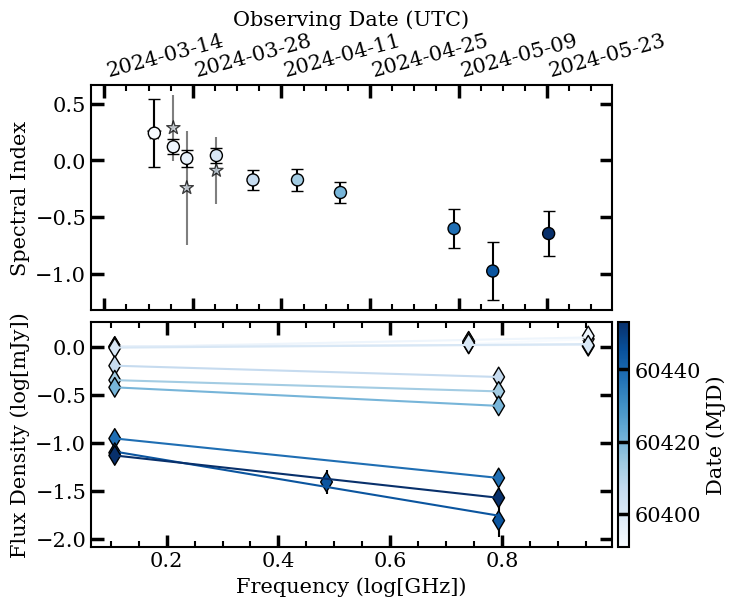

In [11]:
# Re-load the flux files 
xray_flux  = np.genfromtxt('SWJ1717_Files/Xray_flux.txt', skip_header = 1).T
radio_flux = np.genfromtxt('SWJ1717_Files/radio_flux.txt', skip_header = 1).T

# Interpolate the 1.28 GHz flux densities (during the decay) onto the other frequencies during the decay
mkat_index = (radio_flux[0] > 60360) & (radio_flux[-2] < 2.0) & (radio_flux[-1] < 1) # Only meerkat 1.28 GHz
time_index = (radio_flux[0] > 60360) & (radio_flux[-2] > 4.0) & (radio_flux[-1] < 1) # VLA/ATCA data
other_index = (radio_flux[0] > 60360) & (radio_flux[-2] > 2.0) & (radio_flux[-1] < 1) # VLA/ATCA/Meerkat[3.0GHz] data

radio_mkat_interp = two_point_linear_interpolation(np.unique(radio_flux[0,time_index]), radio_flux[0:4,mkat_index], method='log')
radio_mkat_interp[-1] = np.ones(radio_mkat_interp.shape[1]) * 1.28

# Make an array containing the working data to calculate spectral indices
working_data = np.hstack((radio_flux[:-1, other_index], radio_mkat_interp))
working_data = working_data[:, working_data[0].argsort()] 

# Initialize Arrays to save the values
alpha_decay_mjd = np.array([])
alpha_decay     = np.array([])
alpha_decay_err = np.array([])

# Atca only values for comparison
atca_mjd = np.array([])
atca_alpha = np.array([])
atca_alpha_err = np.array([])

# Initialize the figure
fig, ax = plt.subplots(2, figsize = (8,6), gridspec_kw={'hspace': 0.05})
ax = np.atleast_1d(ax)
cm = mpl.colormaps['Blues']

# Simple linear function for curve_fit:
def linear(x, m, b):
    return m * x + b

# Get unique times and counts
times, counts = np.unique(working_data[0], return_counts = True)

# Iterate through the (unique) times
for t, n in zip(times, counts):

    if n > 1:

        # Append time
        alpha_decay_mjd = np.append(alpha_decay_mjd, t)

        # Initialize arrays containing the logged freq/flux values
        y  = np.array([])
        x  = np.array([])
        dy = np.array([])

        # Append values but give one day of 'wiggle room'; All this does is include a single MeerKAT S-band observation one of the later spectral index calculations
        index = np.where(abs(working_data[0] - t) < 1)[0]
        x  = np.append(x,  np.log10(working_data[-1, index]))
        y  = np.append(y,  np.log10(working_data[1, index]))
        dy = np.append(dy, abs(working_data[2, index] / working_data[1,index] / np.log(10)))

        # Sort the arrays by frequency
        sort_index = np.argsort(x)
        x = x[sort_index]
        y = y[sort_index]
        dy = dy[sort_index]
    
        # Fit for the spectral indices and measure error from covariance
        fit, cov = curve_fit(linear, x, y, sigma = dy, absolute_sigma = True)

        # If ATCA data is present (seem by having a frequency > 8.5 GHz), fit the ATCA data for comparison
        if (working_data[-1, index] > 8.5).any():
            atca_fit, atca_cov = curve_fit(linear, x[-2:], y[-2:], sigma = dy[-2:], absolute_sigma = True)
            atca_mjd = np.append(atca_mjd, t)
            atca_alpha = np.append(atca_alpha, atca_fit[0])
            atca_alpha_err = np.append(atca_alpha_err, atca_cov[0,0] ** 0.5)

        # Append the spectral indices
        alpha_decay = np.append(alpha_decay, fit[0])
        alpha_decay_err = np.append(alpha_decay_err, cov[0,0] ** 0.5)
        
        # Plot the data
        cplt = ax[1].scatter(x, y, c = t * np.ones(x.size), zorder=10000, ec='k', cmap=cm, norm = 'linear', s = size, marker=sym, vmin=working_data[0].min(), vmax=working_data[0].max())
        ax[1].errorbar(x, y, dy, c = 'k', fmt = '.')

        # Plot the fit
        xmod = np.linspace(x.min(), x.max(), 3)
        ax[1].plot(xmod, fit[0] * xmod + fit[1], c = cplt.to_rgba(t), zorder=10000, ls='-')

# Finialize plot
fig.colorbar(cplt, ax=ax[1], label="Date (MJD)", shrink = 1, pad = 0.01)
# fig.colorbar(cplt, ax=ax[0], label="Date (MJD)", shrink = 1, pad = 0.01)
ax[0].scatter(Time(alpha_decay_mjd,format='mjd').datetime, alpha_decay, marker = 'o', s = 75, ec = 'k', c = cplt.to_rgba(alpha_decay_mjd), zorder = 1000)
ax[0].errorbar(Time(alpha_decay_mjd,format='mjd').datetime, alpha_decay, alpha_decay_err, fmt = '.', c = 'k', capsize = 4)
ax[0].set_ylabel('Spectral Index', fontsize = 15)
ax[1].set_ylabel('Flux Density (log[mJy])', fontsize = 15)
ax[1].set_xlabel('Frequency (log[GHz])')

# Add the ATCA data to the plot
ax[0].scatter(Time(atca_mjd,format='mjd').datetime, atca_alpha, marker = '*', s = 100, ec = 'k', c = cplt.to_rgba(atca_mjd), zorder = 100, alpha = 0.75)
ax[0].errorbar(Time(atca_mjd,format='mjd').datetime, atca_alpha, atca_alpha_err, fmt = '.', c = 'k', alpha=0.5)

print(atca_mjd)
print(atca_alpha)
print(atca_alpha_err)

# Formatting nonsense
ax[0].set_xlabel('Observing Date (UTC)', fontfamily='serif')  
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax[0].set_xlim(Time(alpha_decay_mjd[0] - 10, format='mjd').datetime,Time(alpha_decay_mjd[-1] + 10, format='mjd').datetime)
ax[0].xaxis.set_label_position('top') 
xformatter = mdates.DateFormatter('%Y-%m-%d')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
ax[0].tick_params(axis='x', which='major',rotation=15, labeltop=True, labelbottom=False)
xlabels = ax[0].get_xticklabels()
ax[0].set_xticklabels(xlabels, rotation=15, ha='left')
#FormatAxis(np.array([ax[0]]), [alpha_decay_mjd[0], alpha_decay_mjd[-1]], interval= 14)

align_axis_x(ax[0], ax[1])
plt.savefig('plots/Decay_spectral_index.pdf', bbox_inches="tight")
plt.show()

# Save the decay spectral indices into a text file
decay_alpha = np.array([alpha_decay_mjd, alpha_decay, alpha_decay_err])
np.savetxt('SWJ1717_Files/alpha_core_decay.txt', decay_alpha.T, header = 'Date (MJD), Spec. Index, Spec. Index Err')

# Save the spectral (both rise and decay) into a single text file
# Load rise alpha
rise_alpha = np.genfromtxt('SWJ1717_Files/alpha_core_rise.txt', skip_header = 1).T

# Concat. the arrays
total_alpha = np.hstack((rise_alpha, decay_alpha))
np.savetxt('SWJ1717_Files/alpha_core.txt', total_alpha.T, header = 'Date (MJD), Spec. Index, Spec. Index Err')

## Calculate Radio and X-ray Luminosities

#### Save the LrLx data at specific distances

*File name convention: `LRLX_[distance].txt`*

In [12]:
# Re-load the flux files 
xray_flux  = np.genfromtxt('SWJ1717_Files/Xray_flux.txt', skip_header = 1).T
radio_flux = np.genfromtxt('SWJ1717_Files/radio_flux.txt', skip_header = 1).T

# Re-load the radio spectral index files
radio_alpha = np.genfromtxt('SWJ1717_Files/alpha_core.txt', skip_header = 1).T

# For times with multiple frequencies, use the one closest to 5 GHz to mitigate errors from spectral index scaling!
# This is a terrible way to do this (likely a more pythonic one) but whatever
index_5GHz = np.array([])
for t in np.unique(radio_flux[0]):

    radio_flux_t = radio_flux[:, radio_flux[0] == t]
    closest_freq = radio_flux_t[-2, np.argmin(abs(radio_flux_t[-2] - 5))]

    index_5GHz = np.append(index_5GHz, np.where((radio_flux[0] == t) & (radio_flux[-2] == closest_freq))[0])

# Trim array
radio_flux = radio_flux[:, index_5GHz.astype(int)]  

# Match the spectral indices closest in time -- it would be trivial to change this to instead:
# e.g., do more interpolation ?!?
# e.g., fit some relation (likely linear) to the spectral index vs. times plots
matched_alpha = np.array([radio_alpha[:, np.argmin(abs(t - radio_alpha[0]))] for t in radio_flux[0]]).T

# Calculate the luminosities and save to a text file -- label based on distance
for D in [1.5, 2.6, 4.3]:

    # X-ray
    lx = 4 * np.pi * xray_flux[1] * (D * 3.086e+21) ** 2
    lx_neg, lx_pos = 4 * np.pi *  xray_flux[2:4] * (D * 3.086e+21) ** 2

    # Radio
    lr = 1e-26 * 4 * np.pi * 5.0e9 * (D * 3.086e+21) ** 2 * radio_flux[1] * (5.0 / radio_flux[-2]) ** matched_alpha[1]
    lr_neg, lr_pos = 1e-26 * 4 * np.pi * 5.0e9 * (D * 3.086e+21) ** 2 * ((radio_flux[2:4] * (5.0 / radio_flux[-2]) ** matched_alpha[1]) ** 2 + (radio_flux[1] * (5.0 / radio_flux[-2]) ** (matched_alpha[1]) * np.log(5.0 / radio_flux[-2]) * matched_alpha[2]) ** 2) ** 0.5

    # For the nominal distance (2.6 kpc) print the rows:  date (ISOT), date (MJD), Lx, Lx_neg, Lx_pos, Lr, Lr_neg, Lr_pos, matched_alpha
    # Write the values to a text file
    if D == 2.6:
        f = open('SWJ1717_Files/latex.txt', 'w')
        for i in range(len(xray_flux[0])):
            f.write('{} & {:.3f} & ${:.3e}_{{{:.3e}}}^{{{:.3e}}}$ & ${:.3e}_{{{:.3e}}}^{{{:.3e}}}$ & ${:.3f} {:.3f} & {} $ \\\\ \n'.format(
                Time(xray_flux[0][i], format='mjd').isot,
                xray_flux[0][i],
                lx[i],
                lx_neg[i],
                lx_pos[i],
                lr[i],
                lr_neg[i],
                lr_pos[i],
                matched_alpha[1][i],
                matched_alpha[2][i],
                radio_flux[-2][i]
            ))
        f.close()
            


    # Save text file
    data_arr = np.array([xray_flux[0], lx, lx_neg, lx_pos, lr, lr_neg, lr_pos, radio_flux[-1]]).T
    np.savetxt('SWJ1717_Files/LRLX_{}kpc.txt'.format(str(D).replace('.','p')), data_arr, header = 'Date (MJD), Lx[1-10keV] (erg/s), Lx_neg[1-10keV] (erg/s), Lx_pos[1-10keV] (erg/s), Lr[5GHz] (erg/s), Lr_neg[5GHz] (erg/s),Lr_pos[5GHz] (erg/s), Lr_uplim (0 - no; 1 - yes)')

## Plot the LrLx without fitting power-laws

/home/andrewhughes/VirtualEnvironments/GenericPython3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


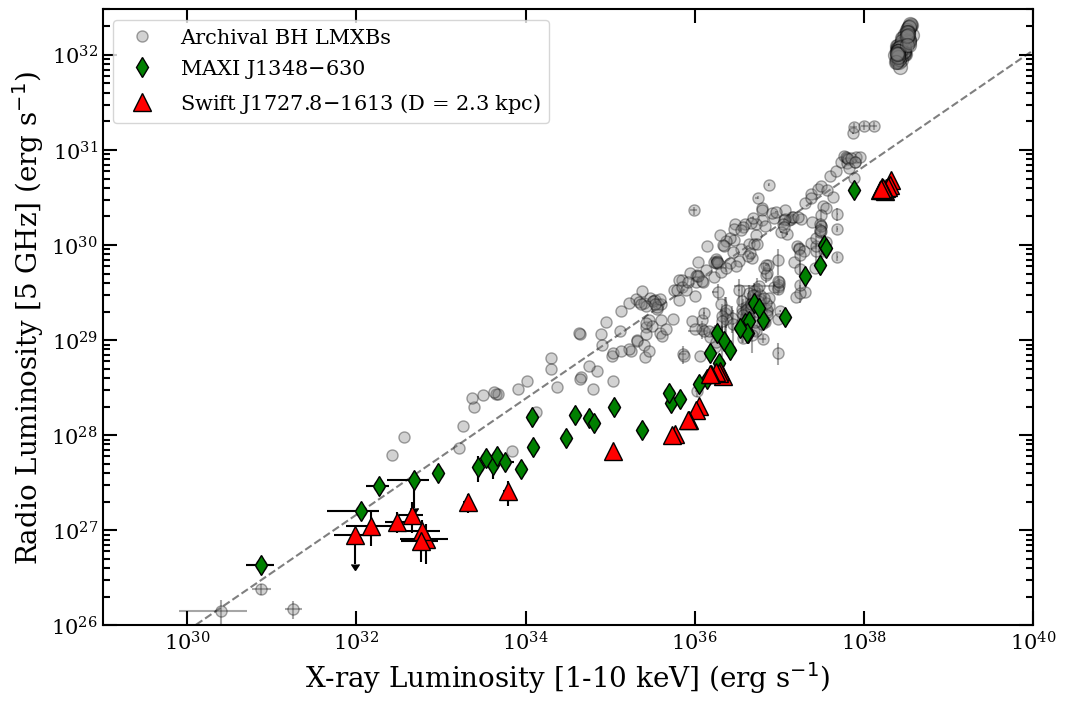

In [13]:
# Format basic axis + add axis labels
font_size=20
fig, ax = plt.subplots(figsize=(12,8))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e29, 1e40)
ax.set_ylim(1e26, 3e32)
ax.set_ylabel(r'Radio Luminosity [5 GHz] (erg s$^{-1}$)', fontsize= font_size, fontfamily='serif')
ax.set_xlabel(r'X-ray Luminosity [1-10 keV] (erg s$^{-1}$)', fontsize= font_size, fontfamily='serif')
ax.tick_params(axis='both', which='minor', direction='in',length=5,width=1.5,top=True,right=True)
ax.tick_params(axis='both', which='major', direction='in',length=10,width=1.5,top=True,right=True, labelsize=15)
ax.minorticks_on()

# Standard track
fit_x = np.logspace(25,45,num=10,base=10)
ax.loglog(fit_x,pow(10,(29.65+0.15-(0.61*36.32)))*pow(fit_x,0.61),'k--',zorder=1,alpha=0.5)

# ----------------------
# Archival sources from: https://github.com/bersavosh/XRB-LrLx_pub

# Load and plot the BH data
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_BHs.csv')
ulim = (data['uplim'] == 'Lr')
ax.errorbar(data['Lx'][~ulim], data['Lr'][~ulim], xerr = [data['Lx_ler'][~ulim], data['Lx_uer'][~ulim]], yerr = [data['Lr_ler'][~ulim], data['Lr_uer'][~ulim]], fmt = 'o', color = 'k', mfc = 'grey', label = 'Archival BH LMXBs', ms = 8, alpha= 0.35)
ax.errorbar(data['Lx'][ulim], data['Lr'][ulim], yerr = data['Lr'][ulim] * 0.5, uplims = True, fmt = 'o', color = 'k', mfc = 'grey', ms = 7, alpha= 0.35)

# Highlight similarities with MAXI J1348
maxi = (data['Name'] == 'MAXI J1348-630')
ulim = (data[maxi]['uplim'] == 'Lr')

ax.errorbar(data['Lx'][maxi][~ulim], data['Lr'][maxi][~ulim], xerr = [data['Lx_ler'][maxi][~ulim], data['Lx_uer'][maxi][~ulim]], yerr = [data['Lr_ler'][maxi][~ulim], data['Lr_uer'][maxi][~ulim]], fmt = 'd', color = 'k', mfc = 'g', label = 'MAXI J1348$-$630', ms = 10, alpha= 1.0)
ax.errorbar(data['Lx'][maxi][ulim], data['Lr'][maxi][ulim], xerr = [data['Lx_ler'][maxi][ulim], data['Lx_uer'][maxi][ulim]], yerr = 0.5 * data['Lr'][maxi][ulim], fmt = 'd', color = 'k', mfc = 'g', uplims = True, ms = 10, alpha= 1.0)


# BH GRS 1915 (weird sources -- but x-ray bright)
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_oddsrcs.csv')
grs = (data['Name'] == 'GRS 1915+105')
ax.errorbar(data['Lx'][grs], data['Lr'][grs], xerr = [data['Lx_ler'][grs], data['Lx_uer'][grs]], yerr = [data['Lr_ler'][grs], data['Lr_uer'][grs]], fmt = 'o', color = 'k', mfc = 'grey', ms = 10, alpha= 0.35)

# -------------------
# Target: Swift J1727

swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_2p6kpc.txt').T
ulim = (swJ1727[-1] > 0.5)
ax.errorbar(swJ1727[1,~ulim], swJ1727[4,~ulim], xerr = swJ1727[2:4,~ulim], yerr = swJ1727[5:7,~ulim], fmt = '^', color = 'k', mfc = 'r', ms = 13, label = f'Swift J1727.8$-$1613 (D = 2.3 kpc)')
ax.errorbar(swJ1727[1,ulim], swJ1727[4,ulim] + 3 * swJ1727[5,ulim], xerr = swJ1727[2:4,ulim], yerr = 0.5 * (swJ1727[4,ulim] + 3 * swJ1727[5,ulim]), uplims = True, fmt = '^', color = 'k', mfc = 'r', ms = 13)

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles,labels, prop={'family':'serif', 'size':15})
plt.savefig('plots/LRLX.pdf')
plt.show()

## Fit broken power law 
### NOTE: fitting in linear space is SUPER Volatile as the residuals become highly non-normal due to the addition of systematic fractional errors (log-space) is better

Where a broken power-law is given by:

$$
    F_R = \begin{cases}
    A(L_X/L_{X,\text{tran}})^{\beta_\text{1}},& \text{if } L_X< L_{X,\text{tran}}\\
    A(L_X/L_{X,\text{tran}})^{\beta_\text{2}},& \text{if } L_X\geq L_{X,\text{tran}}
    \end{cases},
$$

Fit Results (DECAY):
beta1: 3.059e-01 +/- 2.032e-02
beta2: 1.412e+00 +/- 1.458e-01
Ltran_log: 7.013e+35 +/- 9.070e+34
Amp: 6.458e+01 +/- 1.084e-01

Fit Results (All DATA):
beta1: 3.154e-01 +/- 4.000e-02
beta2: 1.020e+00 +/- 1.117e-02
Ltran_log: 5.391e+35 +/- 1.724e+35
Amp: 6.456e+01 +/- 3.191e-01


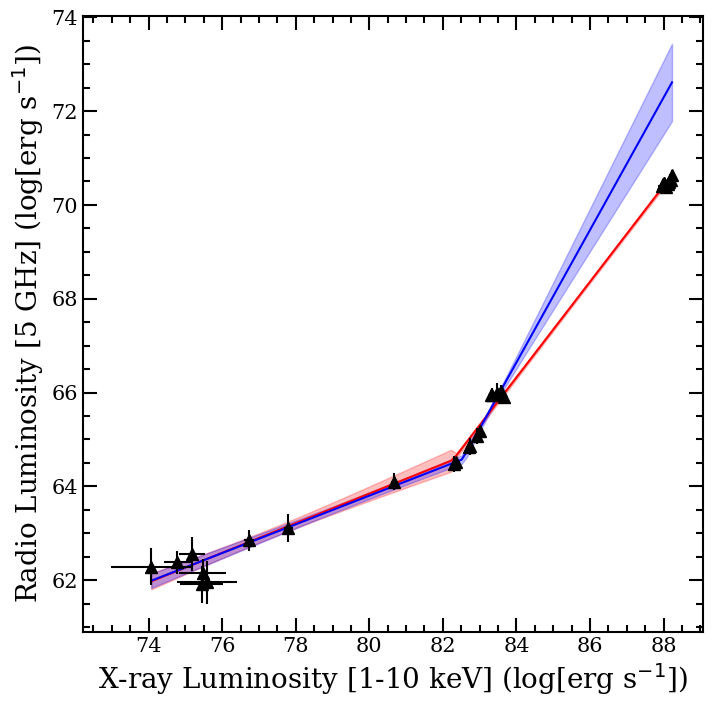

In [14]:
from scipy.odr import ODR, Model, RealData
L_file = 'SWJ1717_Files/LRLX_2p6kpc.txt'


# Define the broken power-law model in log space
def broken_plaw_log(B, Lx_log):
    """
    Broken power-law in log space.
    B[0]: beta1 (slope before the break)
    B[1]: beta2 (slope after the break)
    B[2]: Ltran_log (log of transition luminosity)
    B[3]: Amp (amplitude at the break)
    """
    beta1, beta2, Ltran_log, Amp = B
    result = np.zeros_like(Lx_log)
    mask = Lx_log < Ltran_log
    result[mask] = beta1 * (Lx_log[mask] - Ltran_log) + Amp
    result[~mask] = beta2 * (Lx_log[~mask] - Ltran_log) + Amp
    return result

# Adapted from: https://stackoverflow.com/questions/79028892/how-to-get-errors-on-a-cubic-spline-interpolation-python-splrep-splev
def variance(model, x, p, Cp):
    """
    Calculate the variance of the model predictions based on the covariance matrix of the parameters.

    Parameters:
    - model: The model function.
    - x: The independent variable values.
    - p: The best-fit parameters (array).
    - Cp: The covariance matrix of the parameters.

    Returns:
    - Variance of the model predictions.
    """
    def proxy(q):
        return model(q, x)  # Pass parameters as the first argument

    def projection(J):
        return J @ Cp @ J.T

    # Compute the Jacobian of the model with respect to the parameters
    Jp = nd.Jacobian(proxy)(p)

    # Compute the variance
    Cy = np.apply_along_axis(projection, 1, Jp)

    # Return square root to get sigma
    return Cy ** 0.5

# -------------------
# Fit only the decay
# -------------------

# Open the Text file and trim non-detections
swJ1727 = np.genfromtxt(L_file).T
swJ1727 = swJ1727[:, (swJ1727[-1] < 0.5)]

# This filters out the radio-bright rise
rise = swJ1727[4] > 1e30
swJ1727 = swJ1727[:, ~rise]

# Define the fitting variables
x = np.log(swJ1727[1])  # Independent variable (log of X-ray luminosity)
y = np.log(swJ1727[4])  # Dependent variable (log of radio luminosity)
dy = np.abs(np.amax(swJ1727[5:7], axis=0) / swJ1727[4])  # Errors in y
dx = np.abs(np.amax(swJ1727[2:4], axis=0) / swJ1727[1])  # Errors in x

# Define the data for ODR
data = RealData(x, y, sx=dx, sy=dy)

# Define the model for ODR
model = Model(broken_plaw_log)

# Initialize the parameters [beta1, beta2, Ltran_log, Amp]
beta0 = [0.3, 1.4, np.log(1e35), 5.0]

# Set up the ODR
odr = ODR(data, model, beta0=beta0)

# Run the ODR fit
decay = odr.run()

# Print the fit results
print("Fit Results (DECAY):")
for param_name, param_value, param_error in zip(["beta1", "beta2", "Ltran_log", "Amp"], decay.beta, decay.sd_beta):
    if param_name == "Ltran_log":
        param_value = np.exp(param_value)
        param_error = param_value * param_error
    print(f"{param_name}: {param_value:.3e} +/- {param_error:.3e}")

# -------------------
# Fit all of the data
# -------------------

# Open the Text file and trim non-detections
swJ1727 = np.genfromtxt(L_file).T
swJ1727 = swJ1727[:, (swJ1727[-1] < 0.5)]

# This filters out the radio-bright rise
rise = swJ1727[4] > 5e40
swJ1727 = swJ1727[:, ~rise]

# Define the fitting variables
x = np.log(swJ1727[1])  # Independent variable (log of X-ray luminosity)
y = np.log(swJ1727[4])  # Dependent variable (log of radio luminosity)
dy = np.abs(np.amax(swJ1727[5:7], axis=0) / swJ1727[4])  # Errors in y
dx = np.abs(np.amax(swJ1727[2:4], axis=0) / swJ1727[1])  # Errors in x

# Define the data for ODR
data = RealData(x, y, sx=dx, sy=dy)

# Define the model for ODR
model = Model(broken_plaw_log)

# Set up the ODR
odr = ODR(data, model, beta0=beta0)

# Run the ODR fit
total = odr.run()

# Print the fit results
print("\nFit Results (All DATA):")
for param_name, param_value, param_error in zip(["beta1", "beta2", "Ltran_log", "Amp"], total.beta, total.sd_beta):
    if param_name == "Ltran_log":
        param_value = np.exp(param_value)
        param_error = param_value * param_error
    print(f"{param_name}: {param_value:.3e} +/- {param_error:.3e}")


# ---------------------------------
# Do a bit of comparative plotting
# ---------------------------------

# Reload the non-upper-limit data
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_2p6kpc.txt').T
swJ1727 = swJ1727[:, (swJ1727[-1] < 0.5)]

# Initialize plot
font_size = 20
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_ylabel(r"Radio Luminosity [5 GHz] (log[erg s$^{-1}$])", fontsize=font_size, fontfamily="serif")
ax.set_xlabel(r"X-ray Luminosity [1-10 keV] (log[erg s$^{-1}$])", fontsize=font_size, fontfamily="serif")
ax.tick_params(axis="both", which="minor", direction="in", length=5, width=1.5, top=True, right=True)
ax.tick_params(axis="both", which="major", direction="in", length=10, width=1.5, top=True, right=True, labelsize=15)
ax.minorticks_on()

# Plot SwJ1727 data
ax.errorbar(x, y, xerr=dx, yerr=dy, fmt="^", color="k", mfc="k", ms=8, zorder=10000)

# Broken Power Laws -- total
xmod = np.linspace(x.min(), x.max(), 100)
plt.plot(xmod, broken_plaw_log(total.beta, xmod), c="r", ls="-", zorder=1000)

# Plot the confidence interval
xmod = np.linspace(x.min(), x.max(), 100)
ax.fill_between(
    xmod,
    broken_plaw_log(total.beta, xmod) - variance(broken_plaw_log, xmod, total.beta, total.cov_beta),
    broken_plaw_log(total.beta, xmod) + variance(broken_plaw_log, xmod, total.beta, total.cov_beta),
    alpha=0.25,
    color="r",
    label=r"68% confidence interval",
)

# Broken Power Laws -- Decay
xmod = np.linspace(x.min(), x.max(), 100)
plt.plot(xmod, broken_plaw_log(decay.beta, xmod), c="b", ls="-", zorder=1000)

# Plot the confidence interval
xmod = np.linspace(x.min(), x.max(), 100)
ax.fill_between(
    xmod,
    broken_plaw_log(decay.beta, xmod) - variance(broken_plaw_log, xmod, decay.beta, decay.cov_beta),
    broken_plaw_log(decay.beta, xmod) + variance(broken_plaw_log, xmod, decay.beta, decay.cov_beta),
    alpha=0.25,
    color="b",
    label=r"68% confidence interval",
)

plt.show()


### Same as above (log-space fitting) but now inset into the LrLx diagram

This section repeats the broken power-law fitting of the radio/X-ray luminosity correlation (Lr–Lx) in log space, but now overlays the fit and its confidence intervals as an inset within the main Lr–Lx diagram. 

**Key points:**
- The main plot shows Swift J1727.8-1613 alongside archival black hole LMXBs, highlighting the source's position relative to standard tracks and other systems.
- The inset panel zooms in on Swift J1727.8-1613, displaying the broken power-law fits for both the decay phase and the full dataset, with shaded regions indicating 68% confidence intervals.
- The transition luminosity and changes in slope ("shallow" and "steep" regimes) are annotated for clarity.
- This visualization allows direct comparison of the fitted correlation with the broader population and emphasizes the transition behavior in Swift J1727.8-1613.

Fit Results (DECAY):
beta1: 3.059e-01 +/- 2.032e-02
beta2: 1.412e+00 +/- 1.458e-01
Ltran_log: 7.013e+35 +/- 9.070e+34
Amp: 6.458e+01 +/- 1.084e-01

Fit Results (All DATA):
beta1: 3.224e-01 +/- 2.817e-02
beta2: 1.019e+00 +/- 1.147e-02
Ltran_log: 5.426e+35 +/- 1.126e+35
Amp: 6.458e+01 +/- 1.994e-01


/home/andrewhughes/VirtualEnvironments/GenericPython3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


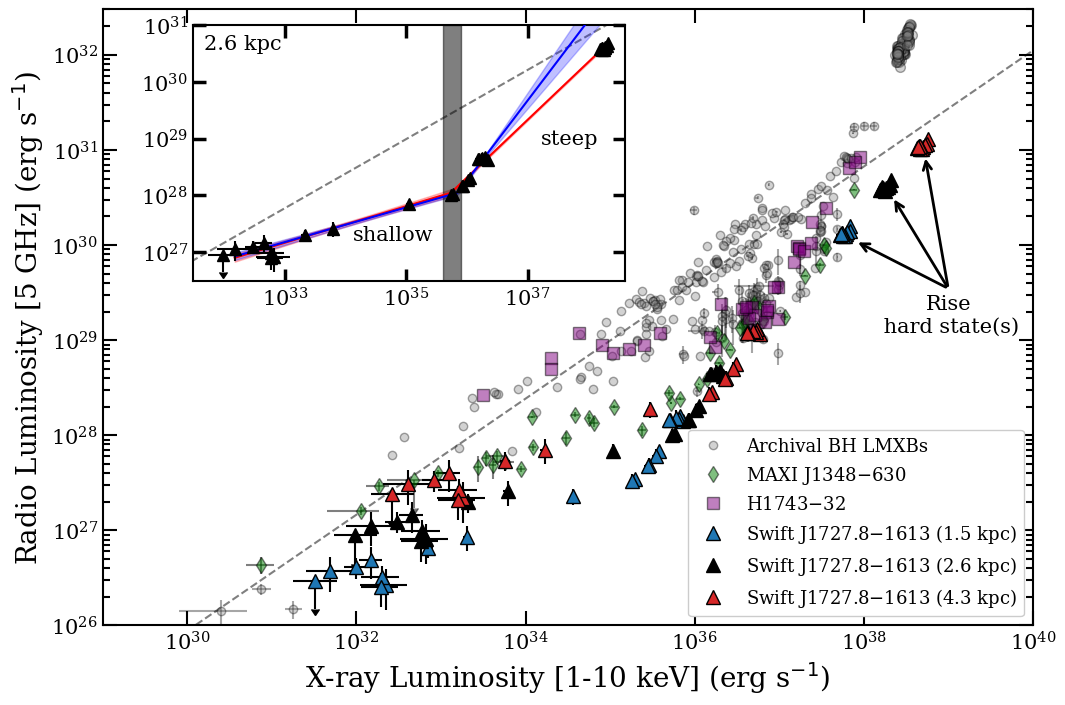

In [15]:
from scipy.odr import ODR, Model, RealData

# Define the broken power-law model in log space
def broken_plaw_log(B, Lx_log):
    """
    Broken power-law in log space.
    B[0]: beta1 (slope before the break)
    B[1]: beta2 (slope after the break)
    B[2]: Ltran_log (log of transition luminosity)
    B[3]: Amp (amplitude at the break)
    """
    beta1, beta2, Ltran_log, Amp = B
    result = np.zeros_like(Lx_log)
    mask = Lx_log < Ltran_log
    result[mask] = beta1 * (Lx_log[mask] - Ltran_log) + Amp
    result[~mask] = beta2 * (Lx_log[~mask] - Ltran_log) + Amp
    return result

# Adapted from: https://stackoverflow.com/questions/79028892/how-to-get-errors-on-a-cubic-spline-interpolation-python-splrep-splev
def variance(model, x, p, Cp):
    """
    Calculate the variance of the model predictions based on the covariance matrix of the parameters.

    Parameters:
    - model: The model function.
    - x: The independent variable values.
    - p: The best-fit parameters (array).
    - Cp: The covariance matrix of the parameters.

    Returns:
    - Variance of the model predictions.
    """
    def proxy(q):
        return model(q, x)  # Pass parameters as the first argument

    def projection(J):
        return J @ Cp @ J.T

    # Compute the Jacobian of the model with respect to the parameters
    Jp = nd.Jacobian(proxy)(p)

    # Compute the variance
    Cy = np.apply_along_axis(projection, 1, Jp)

    # Return square root to get sigma
    return Cy ** 0.5

# -------------------
# Fit only the decay
# -------------------

# Open the Text file and trim non-detections
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_2p6kpc.txt').T
swJ1727 = swJ1727[:, (swJ1727[-1] < 0.5)]

# This filters out the radio-bright rise
rise = swJ1727[4] > 1e30
swJ1727 = swJ1727[:, ~rise]

# Define the fitting variables
x = np.log(swJ1727[1])  # Independent variable (log of X-ray luminosity)
y = np.log(swJ1727[4])  # Dependent variable (log of radio luminosity)
dy = np.abs(np.amax(swJ1727[5:7], axis=0) / swJ1727[4])  # Errors in y
dx = np.abs(np.amax(swJ1727[2:4], axis=0) / swJ1727[1])  # Errors in x

# Define the data for ODR
data = RealData(x, y, sx=dx, sy=dy)

# Define the model for ODR
model = Model(broken_plaw_log)

# Initialize the parameters [beta1, beta2, Ltran_log, Amp]
beta0 = [0.3, 1.4, np.log(1e36), 5.0]

# Set up the ODR
odr = ODR(data, model, beta0=beta0)

# Run the ODR fit
decay = odr.run()

# Print the fit results
print("Fit Results (DECAY):")
for param_name, param_value, param_error in zip(["beta1", "beta2", "Ltran_log", "Amp"], decay.beta, decay.sd_beta):
    if param_name == "Ltran_log":
        param_value = np.exp(param_value)
        param_error = param_value * param_error
    print(f"{param_name}: {param_value:.3e} +/- {param_error:.3e}")

# -------------------
# Fit all of the data
# -------------------

# Open the Text file and trim non-detections
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_2p6kpc.txt').T
swJ1727 = swJ1727[:, (swJ1727[-1] < 0.5)]

# This filters out the radio-bright rise
rise = swJ1727[4] > 5e40
swJ1727 = swJ1727[:, ~rise]

# Define the fitting variables
x = np.log(swJ1727[1])  # Independent variable (log of X-ray luminosity)
y = np.log(swJ1727[4])  # Dependent variable (log of radio luminosity)
dy = np.abs(np.amax(swJ1727[5:7], axis=0) / swJ1727[4])  # Errors in y
dx = np.abs(np.amax(swJ1727[2:4], axis=0) / swJ1727[1])  # Errors in x

# Define the data for ODR
data = RealData(x, y, sx=dx, sy=dy)

# Define the model for ODR
model = Model(broken_plaw_log)

# Initialize the parameters [beta1, beta2, Ltran_log, Amp]
beta0 = [0.3, 1.4, np.log(1e36), 5.0]

# Set up the ODR
odr = ODR(data, model, beta0=beta0)

# Run the ODR fit
total = odr.run()

# Print the fit results
print("\nFit Results (All DATA):")
for param_name, param_value, param_error in zip(["beta1", "beta2", "Ltran_log", "Amp"], total.beta, total.sd_beta):
    if param_name == "Ltran_log":
        param_value = np.exp(param_value)
        param_error = param_value * param_error
    print(f"{param_name}: {param_value:.3e} +/- {param_error:.3e}")

# --------------------------------------------------------------------
# Make the final plots -- scaling to linear space and placing on LrLx
# --------------------------------------------------------------------

# Configure plot
font_size = 20
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(1e29, 1e40)
ax.set_ylim(1e26, 3e32)
ax.set_ylabel(r'Radio Luminosity [5 GHz] (erg s$^{-1}$)', fontsize=font_size, fontfamily='serif')
ax.set_xlabel(r'X-ray Luminosity [1-10 keV] (erg s$^{-1}$)', fontsize=font_size, fontfamily='serif')
ax.tick_params(axis='both', which='minor', direction='in', length=5, width=1.5, top=True, right=True)
ax.tick_params(axis='both', which='major', direction='in', length=10, width=1.5, top=True, right=True, labelsize=15)
ax.minorticks_on()

# Standard track
fit_x = np.logspace(25,45,num=10,base=10)
ax.loglog(fit_x,pow(10,(29.65+0.15-(0.61*36.32)))*pow(fit_x,0.61),'k--',zorder=1,alpha=0.5)

# Load and plot the BH data
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_BHs.csv')
maxi = (data['Name'] != 'H 1743-322' ) & (data['Name'] != 'MAXI J1348-630')
ulim = (data['uplim'] == 'Lr')
ax.errorbar(data['Lx'][maxi][~ulim], data['Lr'][maxi][~ulim], xerr = [data['Lx_ler'][maxi][~ulim], data['Lx_uer'][maxi][~ulim]], yerr = [data['Lr_ler'][maxi][~ulim], data['Lr_uer'][maxi][~ulim]], fmt = 'o', color = 'k', mfc = 'grey', label = 'Archival BH LMXBs', ms = 6, alpha= 0.35)
ax.errorbar(data['Lx'][maxi][ulim], data['Lr'][maxi][ulim], yerr = data['Lr'][maxi][ulim] * 0.5, uplims = True, fmt = 'o', color = 'k', mfc = 'grey', ms = 7, alpha= 0.35)

# Include BH GRS 1915 (weird sources -- but x-ray bright)
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_oddsrcs.csv')
grs = (data['Name'] == 'GRS 1915+105')
ax.errorbar(data['Lx'][grs], data['Lr'][grs], xerr = [data['Lx_ler'][grs], data['Lx_uer'][grs]], yerr = [data['Lr_ler'][grs], data['Lr_uer'][grs]], fmt = 'o', color = 'k', mfc = 'grey', ms = 7, alpha= 0.35)

# # Highlight  MAXI J1348
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_BHs.csv')
maxi = (data['Name'] == 'MAXI J1348-630')
ulim = (data[maxi]['uplim'] == 'Lr')
ax.errorbar(data['Lx'][maxi][~ulim], data['Lr'][maxi][~ulim], xerr = [data['Lx_ler'][maxi][~ulim], data['Lx_uer'][maxi][~ulim]], yerr = [data['Lr_ler'][maxi][~ulim], data['Lr_uer'][maxi][~ulim]], fmt = 'd', color = 'k', mfc = 'g', label = 'MAXI J1348$-$630', ms = 8, alpha= 0.5)
ax.errorbar(data['Lx'][maxi][ulim], data['Lr'][maxi][ulim], xerr = [data['Lx_ler'][maxi][ulim], data['Lx_uer'][maxi][ulim]], yerr = 0.5 * data['Lr'][maxi][ulim], fmt = 'd', color = 'k', mfc = 'g', uplims = True, ms = 8, alpha= 0.5)

# # Highlight  H1743 32
data = pd.read_csv('LrLx_Catalog_Files/lrlx_data_BHs.csv')
maxi = (data['Name'] == 'H 1743-322')
ulim = (data[maxi]['uplim'] == 'Lr')
ax.errorbar(data['Lx'][maxi][~ulim], data['Lr'][maxi][~ulim], xerr = [data['Lx_ler'][maxi][~ulim], data['Lx_uer'][maxi][~ulim]], yerr = [data['Lr_ler'][maxi][~ulim], data['Lr_uer'][maxi][~ulim]], fmt = 's', color = 'k', mfc = 'purple', label = 'H1743$-$32', ms = 8, alpha= 0.5)
ax.errorbar(data['Lx'][maxi][ulim], data['Lr'][maxi][ulim], xerr = [data['Lx_ler'][maxi][ulim], data['Lx_uer'][maxi][ulim]], yerr = 0.5 * data['Lr'][maxi][ulim], fmt = 's', color = 'k', mfc = 'purple', uplims = True, ms = 8, alpha= 0.5)


# Target: Swift J1727 lower bound
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_1p5kpc.txt').T
ulim = (swJ1727[-1] > 0.5)
ax.errorbar(swJ1727[1,~ulim], swJ1727[4,~ulim], xerr = swJ1727[2:4,~ulim], yerr = swJ1727[5:7,~ulim], fmt = '^', color = 'k', mfc = 'C0', ms = 10, label = 'Swift J1727.8$-$1613 (1.5 kpc)')
ax.errorbar(swJ1727[1,ulim], swJ1727[4,ulim] + 3 * swJ1727[5,ulim], xerr = swJ1727[2:4,ulim], yerr = 0.5 * (swJ1727[4,ulim] + 3 * swJ1727[5,ulim]), uplims = True, fmt = '^', color = 'k', mfc = 'C0', ms = 10)

# Target: Swift J1727 -- nominal distance
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_2p6kpc.txt').T
ulim = (swJ1727[-1] > 0.5)
ax.errorbar(swJ1727[1,~ulim], swJ1727[4,~ulim], xerr = swJ1727[2:4,~ulim], yerr = swJ1727[5:7,~ulim], fmt = '^', color = 'k', mfc = 'k', ms = 10, label = 'Swift J1727.8$-$1613 (2.6 kpc)')
ax.errorbar(swJ1727[1,ulim], swJ1727[4,ulim] + 3 * swJ1727[5,ulim], xerr = swJ1727[2:4,ulim], yerr = 0.5 * (swJ1727[4,ulim] + 3 * swJ1727[5,ulim]), uplims = True, fmt = '^', color = 'k', mfc = 'k', ms = 10)

# Target: Swift J1727 lower bound
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_4p3kpc.txt').T
ulim = (swJ1727[-1] > 0.5)
ax.errorbar(swJ1727[1,~ulim], swJ1727[4,~ulim], xerr = swJ1727[2:4,~ulim], yerr = swJ1727[5:7,~ulim], fmt = '^', color = 'k', mfc = 'C3', ms = 10, label = 'Swift J1727.8$-$1613 (4.3 kpc)')
ax.errorbar(swJ1727[1,ulim], swJ1727[4,ulim] + 3 * swJ1727[5,ulim], xerr = swJ1727[2:4,ulim], yerr = 0.5 * (swJ1727[4,ulim] + 3 * swJ1727[5,ulim]), uplims = True, fmt = '^', color = 'k', mfc = 'C3', ms = 10)

# -------------------------------
# Inset panel to highlight fit  
# -------------------------------

left, bottom, width, height = [0.20, 0.54, 0.36, 0.32]
ax_inset = fig.add_axes([left, bottom, width, height])
ax_inset.set_yscale('log')
ax_inset.set_xscale('log')
ax_inset.minorticks_on()
ax_inset.set_xlim(3e31, 4e38)
ax_inset.set_ylim(3e26, 1e31)
ax_inset.loglog(fit_x, pow(10,(29.65+0.15-(0.61*36.32))) * pow(fit_x,0.61), 'k--', zorder=1, alpha=0.5)

# Plot SwJ1727 data
swJ1727 = np.genfromtxt('SWJ1717_Files/LRLX_2p6kpc.txt').T
ulim = (swJ1727[-1] > 0.5)
ax_inset.errorbar(swJ1727[1,~ulim], swJ1727[4,~ulim], xerr = swJ1727[2:4,~ulim], yerr = swJ1727[5:7,~ulim], fmt = '^', color = 'k', mfc = 'k', ms = 8, zorder=10000)
ax_inset.errorbar(swJ1727[1,ulim], swJ1727[4,ulim] + 3 * swJ1727[5,ulim], xerr = swJ1727[2:4,ulim], yerr = 0.5 * (swJ1727[4,ulim] + 3 * swJ1727[5,ulim]), uplims = True, fmt = '^', color = 'k', mfc = 'k', ms = 8, zorder=10000)


# Broken Power Laws -- total
xmod = np.linspace(x.min(), x.max(), 100)
ax_inset.plot(np.exp(xmod), np.exp(broken_plaw_log(total.beta, xmod)), c="r", ls="-", zorder=1000)

# Plot the confidence interval
ax_inset.fill_between(
    np.exp(xmod),
    np.exp(broken_plaw_log(total.beta, xmod) - variance(broken_plaw_log, xmod, total.beta, total.cov_beta)),
    np.exp(broken_plaw_log(total.beta, xmod) + variance(broken_plaw_log, xmod, total.beta, total.cov_beta)),
    alpha=0.25,
    color="r",
    label=r"68% confidence interval",
)

# Broken Power Laws -- Decay
ax_inset.plot(np.exp(xmod), np.exp(broken_plaw_log(decay.beta, xmod)), c="b", ls="-", zorder=1000)

# Plot the confidence interval
ax_inset.fill_between(
    np.exp(xmod),
    np.exp(broken_plaw_log(decay.beta, xmod) - variance(broken_plaw_log, xmod, decay.beta, decay.cov_beta)),
    np.exp(broken_plaw_log(decay.beta, xmod) + variance(broken_plaw_log, xmod, decay.beta, decay.cov_beta)),
    alpha=0.25,
    color="b",
    label=r"68% confidence interval",
)


# Add text to the inset panel
ax_inset.text(6e34, 2e27, "shallow", 
              fontsize=15, fontfamily='serif', color='black', ha='center', va='center')     
ax_inset.text(5e37, 1e29, "steep", 
              fontsize=15, fontfamily='serif', color='black', ha='center', va='center')   
ax_inset.axvspan(4.0e35,8.0e35, color='k', lw=1, ls='-', alpha=0.5)

# # Add the rectangular box and label to the main plot -- 4.3kpc
# xmin = 2.6e38  # Minimum x-coordinate in data units
# xmax = 0.95e39  # Maximum x-coordinate in data units
# ymin = 0.7e31  # Minimum y-coordinate in data units
# ymax = 1.8e31  # Maximum y-coordinate in data units

# # Add the rectangle
# rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
#                      edgecolor='k', facecolor='none', lw=3, ls ='--', zorder=10)
# ax.add_patch(rect)


# Add the label below the rectangles
ax.text(1e39,3e29, 'Rise\n hard state(s)', color='k', fontsize=15, fontfamily='serif',
        ha='center', va='top', zorder=10)

# Add arrow to the main plot
arrowprops = dict(facecolor='black', arrowstyle='->', lw=2)
for xy in [(2.2e38, 3.2e30), (5.3e38, 8.7e30), (8e37, 1.1e30)]:
    ax.annotate('', xytext=(1e39, 3.5e29), xy=xy,
            arrowprops=arrowprops, fontsize=15, fontfamily='serif', color='black',
            ha='center', va='top', zorder=10)


# Label the inset
ax_inset.text(2e32, 7e30, '2.6 kpc', color='k', fontsize=15, fontfamily='serif', ha='center', va='top', zorder=10)

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles,labels,ncol=1,prop={'family':'serif', 'size':13}, loc='lower right', framealpha = 1.0)
plt.savefig('plots/LRLX_inset.pdf', bbox_inches='tight')
plt.show()


# Spectral and Photometric Evolution During the Decay

This section analyzes the evolution of both the radio and X-ray properties of Swift J1727.8-1613 during the decay phase of its outburst.

**Panels in the following plot:**
1. **Radio core flux densities** from ATCA, MeerKAT, and VLA (with frequency color-coding and upper limits).
2. **Radio spectral index** evolution, including both broadband and ATCA-only measurements.
3. **X-ray flux** (1–10 keV), highlighting the transition luminosity range.
4. **X-ray photon index ($\Gamma$)**, showing both individual measurements and the variance-weighted average for the late decay.

**Purpose:**  
To provide a comprehensive view of the coupled spectral and photometric changes in both bands, highlighting correlations and transitions during the decay.

Gamma average: 1.774 +/- 0.092 / 0.092


/tmp/ipykernel_10774/892713787.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(xlabels, rotation=15, ha='left')
/tmp/ipykernel_10774/1709897130.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


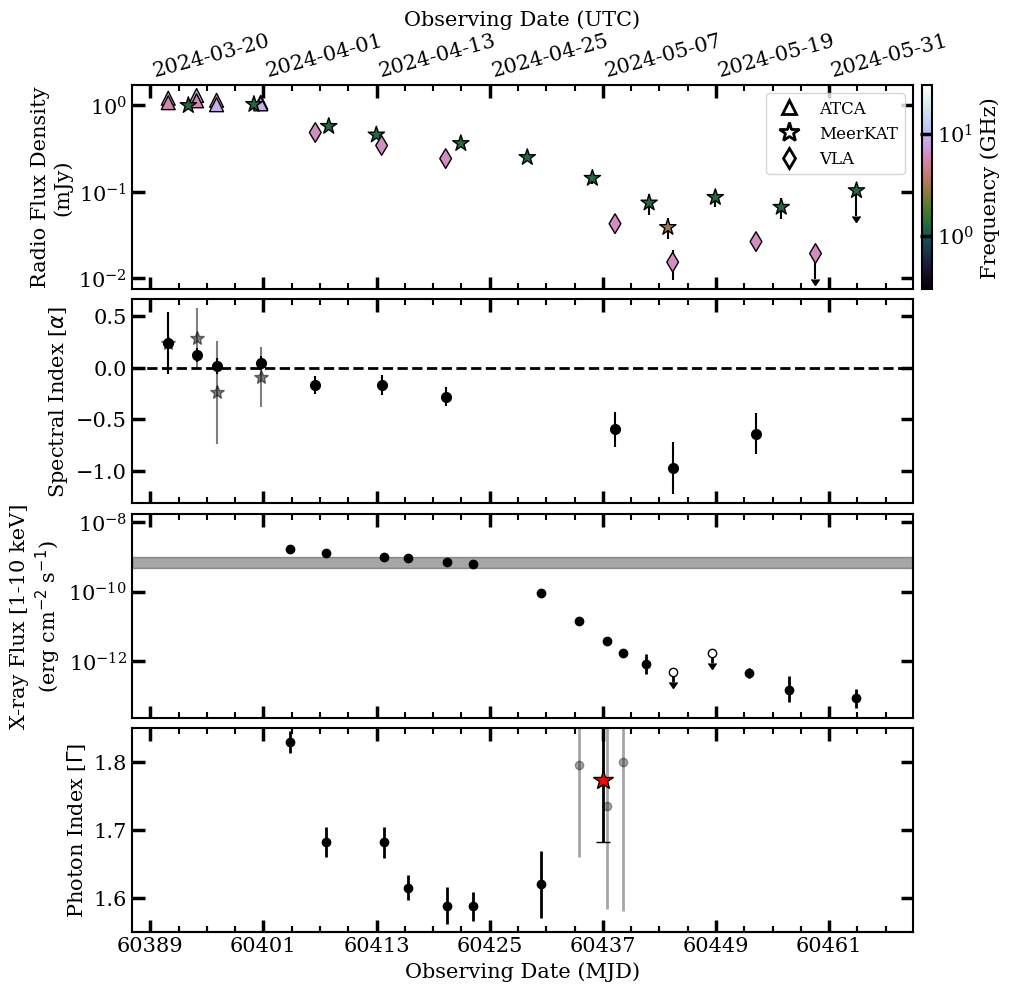

In [16]:
font_size = 15

# Load in the radio data 
atca = np.genfromtxt('SWJ1717_Files/ATCA_core_decay_sub.txt', skip_header = 1).T
mkat = np.genfromtxt('SWJ1717_Files/MeerKAT_core_decay_sub.txt', skip_header = 1).T[:,5:]
vla = np.genfromtxt('SWJ1717_Files/VLA_core_decay_sub.txt', skip_header = 1).T

# Load in the X-ray data
decay_flux = np.genfromtxt('SWJ1717_Files/XRT_decay.txt', skip_header = 1).T
Dscale = 4 * np.pi * (2.6e3 * 3.086e18) ** 2

# Load in the X-ray Photon Indices
gamma = np.genfromtxt('SWJ1717_Files/gamma_decay.txt', skip_header = 1).T

# Caclulate the variance-weighted average of Gamma for the last few data
i = -3
f = len(gamma[0])
gamma_avg_time = Time(np.mean(gamma[0,i:f]), format='mjd').datetime
gamma_avg = np.average(gamma[4,i:f], weights = 1/gamma[5,i:f]**2)
gamma_avg_neg = np.sum(1./gamma[5,i:f]**2) ** (-0.5)
gamma_avg_pos = np.sum(1./gamma[6,i:f]**2) ** (-0.5)

print(f"Gamma average: {gamma_avg:.3f} +/- {gamma_avg_pos:.3f} / {gamma_avg_neg:.3f}")

# Load in the Radio spectral indices
alpha = np.genfromtxt('SWJ1717_Files/alpha_core_decay.txt', skip_header = 1).T

# ATCA-only spectra indices
atca_spec_time = Time([60390.90653935, 60393.91284722, 60396.03165509, 60400.71493056], format='mjd').datetime
atca_spec = np.array([ 0.2403972,   0.28734734, -0.24081824, -0.08864958])
atca_spec_err = np.array([0.29752727, 0.28801156, 0.4995237,  0.29256852])

# Set up the figure
fig, ax = plt.subplots(4, 1, figsize=(12, 11), sharex=True, gridspec_kw={'hspace': 0.05})

# --- Panel 1: Radio Flux (ATCA, MeerKAT, VLA) ---
cm = mpl.colormaps['cubehelix']
symbol = {'ATCA': '^', 'MeerKAT': '*', 'VLA': 'd'}
size = {'ATCA': 100, 'MeerKAT': 150, 'VLA': 100}
labels = {'ATCA': 'ATCA', 'MeerKAT': 'MeerKAT', 'VLA': 'VLA'}
radio_data = {'ATCA': atca, 'MeerKAT': mkat, 'VLA': vla}
cplt = None

for tele, arr in radio_data.items():
    ulim = arr[-1].astype(bool)
    dt = Time(arr[0], format='mjd').datetime
    # Detections
    cplt = ax[0].scatter(dt[~ulim], arr[1][~ulim], c=arr[-2][~ulim], zorder=10000, ec='k', cmap=cm, norm='log',
                          s=size[tele], marker=symbol[tele], vmin=0.3, vmax=30., label=labels[tele])
    ax[0].errorbar(dt[~ulim], arr[1][~ulim], arr[2][~ulim], fmt='.', ecolor='k')
    # Upper limits
    ax[0].scatter(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], c=arr[-2][ulim], zorder=10000, ec='k', cmap=cm, norm='log',
                   s=size[tele], marker=symbol[tele], vmin=0.3, vmax=30.)
    ax[0].errorbar(dt[ulim], arr[1][ulim] + 3 * arr[2][ulim], 0.5 * (arr[1][ulim] + 3 * arr[2][ulim]), fmt='.', ecolor='k', uplims=True)

ax[0].set_ylabel('Radio Flux Density\n(mJy)', fontfamily='serif', fontsize=font_size)
ax[0].set_yscale('log')
ax[0].legend(handles=legend_elements, fontsize=12, ncol=1)
fig.colorbar(cplt, ax=ax[0], label="Frequency (GHz)", shrink=1, pad=0.01)

# # --- Panel 2: Radio Spectral Index ---
ax[1].errorbar(Time(alpha[0], format='mjd').datetime, alpha[1], alpha[2], fmt='o', mec='k', ecolor='k', color='k', ms=7)
ax[1].errorbar(atca_spec_time, atca_spec, yerr=atca_spec_err, fmt='*', mec='k', ecolor='k', color='k', ms=10, alpha=0.5)
ax[1].set_ylabel(r'Spectral Index [$\alpha$]', fontfamily='serif', fontsize=font_size)
ax[1].axhline(0.0, color='k', lw=2, ls='--')

# # --- Panel 3: X-ray Flux ---
ulim = decay_flux[-1] < 0.5
ax[2].errorbar(Time(decay_flux[0,ulim], format='mjd').datetime, decay_flux[1,ulim], yerr=[decay_flux[2,ulim], decay_flux[3,ulim]],
                color='k', lw=2, fmt='o', label='X-ray Flux')
ax[2].errorbar(Time(decay_flux[0,~ulim], format='mjd').datetime, decay_flux[1,~ulim], yerr = 0.5 * decay_flux[1,~ulim], uplims=True,
                color='k', lw=2, fmt='o', mfc ='w', label='X-ray Flux')
ax[2].set_yscale('log')
ax[2].set_ylabel('X-ray Flux [1-10 keV]\n(erg cm$^{-2}$ s$^{-1}$)', fontfamily='serif', fontsize=font_size)
ax[2].axhspan(4.0e35/Dscale,8.0e35/Dscale, color='k', lw=1, ls='-', alpha=0.35)

# --- Panel 4: Gamma (X-ray Photon Index) ---
ax[3].errorbar(Time(gamma[0], format='mjd').datetime[:i], gamma[4][:i], yerr = [gamma[5][:i], gamma[6][:i]], color='k', lw=2, fmt = 'o')
ax[3].errorbar(Time(gamma[0], format='mjd').datetime[i:f], gamma[4][i:f], yerr = [gamma[5][i:f], gamma[6][i:f]], color='k', lw=2, fmt = 'o', alpha=0.35)
ax[3].set_ylim(1.55,1.85)
ax[3].errorbar([gamma_avg_time], [gamma_avg], yerr = [[gamma_avg_neg],[gamma_avg_pos]], color='r', lw=2, fmt = '*', mec='k', ms = 15, capsize = 5, ecolor='k')
ax[3].set_ylabel(r'Photon Index [$\Gamma$]', fontsize=font_size, fontfamily='serif')

# Format x-axis with UTC on top and MJD on bottom
ax[-1].tick_params(labelbottom=False)
FormatAxis(ax, mkat[0], dt=6, interval=12)

# Align axes
for i in range(0, 4):
    #ax[i].axvline(Time(60387, format='mjd').datetime, color='k', lw=2, ls='--')
    if i > 0:
        align_axis_x(ax[i], ax[0])

plt.tight_layout()
plt.savefig('plots/Spectral_Decay.pdf', bbox_inches='tight')
plt.show()

### Transitional Luminosity work

The critical mass accretion rate (which is related to the, luminosity) can be expressed as (Yuan2012, 1207.3113).

Where they define $\dot{M}_{edd} = 10L_{edd}/c^2$: or $\eta = 0.1$ (thin-disk) for $L_{edd} = \eta \dot{M}_{edd}c^2$ :

$$
\dot{M}_C \sim 5\alpha^2\theta_e^{5/3}\dot{M}_{edd}
$$

Which could be rewritting in terms of luminosity recognizing that,

$$
\frac{L_C}{\eta c^2} \sim 5\alpha^2\theta_e^{5/3}\frac{10L_\text{edd}}{c^2}
$$ 

or

$$
L_C\sim \eta50\alpha^2\theta_e^{5/3}L_\text{edd}
$$ 

substituting in $L_\text{edd} = 1.26\times10^{38}(M_\text{BH}/M_\odot)$ erg/s, and setting $L_C \lesssim L_{X,trans}$ (i.e., the transition occurs along the shallow track)

where, from our fitting, $L_{X,trans} {\sim} 6\times10^{35}(D/2.6kpc)^2$ erg/s, we can approximate

$$
M_\text{BH}\,{\lesssim}\, 10^{-4}\eta^{-1}\alpha^{-2}\theta_e^{-3/2}(D/2.6kpc)^2
$$

where the leading constant is just $6{\times}10^{35} /(1.26 {\times} 10^{38}) / 50$

The other parameters $\alpha\, {\sim}\, 0.1$ (but can go as high as $\sim$ 1 ; 1801.07203) 

and the electron temperature is parameterized with $\theta_e \equiv kT_e / m_ec^2$ where it seems to be $kT_e \sim 10{-}1000\,$ keV (1912.12145)

If we (conservatively?) fix $\eta_\text{max} = 0.01$, we get

$$
M_\text{BH}\,{\lesssim}\, 10^{-2}\alpha^{-2}\theta_e^{-3/2}(D/2.6kpc)^2
$$

which still may still be useful for (loose constraints), for instance, adoptig the lower bound distance
$D = 1.5$ kpc, $\alpha{>}0.6$, $\theta_e > 60\, kev$

would suggest $M_\text{BH}\,{\lesssim} 1 M_\odot$


In [149]:
# Function to calculate the electron temperature proxy (dimensionless)
def theta_e(kT):
    '''
    Calculate the dimensionless electron temperature proxy (theta_e).

    Parameters:
    - kT (float or array): Electron temperature in keV.

    Returns:
    - theta_e (float or array): Dimensionless electron temperature proxy, defined as kT / (m_e * c^2).
    '''

    # Convert temperature from keV to erg
    kT = kT * 1e3 * 1.60218e-12  # 1 keV = 1.60218e-9 erg

    # Constants
    m_e = 9.11e-28  # Electron mass in grams
    c = 2.998e10  # Speed of light in cm/s

    # Calculate the electron temperature proxy
    theta_e = kT / (m_e * c ** 2)  # Dimensionless temperature

    return theta_e ** (3/2)

# Calculate the coeffieint
const = 6e35 / 1.26e38 / 50
print('Coefficient is, ', const)

# Example
eta = 0.01
alpha_nu = 0.6
D = 1.5
D0 = 2.6
theta_e = theta_e(60)

mlim = const / eta / theta_e ** (3/2) / alpha_nu ** (2) * (D / D0) ** 2
print('Minimum black hole mass is, ', mlim, 'Msun')

Coefficient is,  9.523809523809523e-05
Minimum black hole mass is,  1.0913447074590767 Msun


# Scaling calculations for the luminosity conversion

In [17]:
# Load in 2.6 kpc luminosity data
swJ1727_2p6kpc = np.genfromtxt('SWJ1717_Files/LRLX_2p6kpc.txt').T

# Load in 4.3 kpc luminosity data
swJ1727_4p3kpc = np.genfromtxt('SWJ1717_Files/LRLX_4p3kpc.txt').T

# Load in Xray flux data 
swJ1727_xray = np.genfromtxt('SWJ1717_Files/Xray_flux.txt').T

# Load in radio flux data
swJ1727_radio = np.genfromtxt('SWJ1717_Files/radio_flux.txt').T

# Load in spectral index data
swJ1727_alpha = np.genfromtxt('SWJ1717_Files/alpha_core.txt').T

# Calculate scaling for X-ray flux:
xray_factor = 4 * np.pi * (2.6 * 3.086e+21) ** 2 * 1e-7
radio_factor = 4 * np.pi * (2.6 * 3.086e+21) ** 2 * 5.0e9 * 1e-26

# Maximum fluxes
print('Maximum X-ray flux: ', np.amax(swJ1727_xray[1]))
print('Maxmum Radio flux: ', np.amax(swJ1727_radio[1]))

# Print factors
print('\nX-ray factor: ', xray_factor)
print('Radio factor: ', radio_factor)

# Compare values:
print('\nX-ray test (4.3 kpc)') 
print('X-ray flux: ', xray_factor * (swJ1727_xray[1,0] / 1e-7) * (4.3 / 2.6)**2)
print('X-ray luminosity: ', swJ1727_4p3kpc[1,0])

print('\nRadio test (4.3 kpc)') 
print('Radio flux: ', radio_factor * swJ1727_radio[1,0] * (4.3 / 2.6) ** 2 * (5.0 / swJ1727_radio[-2,0]) ** swJ1727_alpha[1,2])
print('Radio luminosity: ', swJ1727_4p3kpc[4,0])

Maximum X-ray flux:  2.5713434455351767e-07
Maxmum Radio flux:  118.73

X-ray factor:  8.089997798287465e+37
Radio factor:  4.0449988991437325e+28

X-ray test (4.3 kpc)
X-ray flux:  5.6898223433838566e+38
X-ray luminosity:  5.689822343383856e+38

Radio test (4.3 kpc)
Radio flux:  1.3157687698839232e+31
Radio luminosity:  1.3157687698839232e+31
